In [ ]:
!pip install facenet-pytorch
!pip install Pillow
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]
!pip install matplotlib

In [2]:
# LIBRERIE UTILI
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from matplotlib import pyplot as plt
import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


In [32]:
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True



fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.

# **FSGM ATTACK**

In [4]:
# Import the attack
from art.attacks.evasion import FastGradientMethod
from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
from torchvision import transforms
from PIL import Image

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    return tns

model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.

test_img = load_image("test_set_cropped/Antonio_Cassano_8_face_0.jpg")

print(test_img.shape)
print(test_img.size)
test_img = test_img.unsqueeze(0)
print(test_img.shape)
print(test_img.size)
test_img = test_img.numpy()
print(test_img.shape)
print(type(test_img))

torch.Size([3, 160, 160])
<built-in method size of Tensor object at 0x32f70b860>
torch.Size([1, 3, 160, 160])
<built-in method size of Tensor object at 0x32e487d10>
(1, 3, 160, 160)
<class 'numpy.ndarray'>


**NON TARGETED**

In [ ]:
#FSGM generic Attack for single sample

epsilon = 0.0005
attack = FastGradientMethod(estimator=model, eps=epsilon, targeted=False)
batch_size = test_img.shape[0]
targeted_labels = np.array([2] * batch_size)   #Al posto di 2 ci va l'indice della label della persona
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)   #Creazione attacco
test_images_adv = attack.generate(test_img)                                 # Generazione campione avversario
model_predictions = model.predict(test_images_adv)
loss = model.compute_loss(test_images_adv,one_hot_targeted_labels)                          # Predizione
perturbation = np.mean(np.abs((test_images_adv - test_img)))
predicted_label = LABELS[np.array(model_predictions[0].argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))


In [ ]:
import os
import re

dataset_dir = "test_set_cropped"

#FSGM generic Attack for all samples

correct_predictions = 0
total_images = 0
eps_range = [0.001, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7]
accuracy_plot = []
for epsilon in eps_range:
    correct_predictions = 0
    total_images = 0
    attack = FastGradientMethod(estimator=model, eps=epsilon, targeted=False)

    for filename in os.listdir(dataset_dir):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            person_path = os.path.join(dataset_dir, filename)
            test_img = load_image(person_path)
            test_img = test_img.unsqueeze(0)
            test_img = test_img.numpy()
            test_images_adv = attack.generate(test_img)
            model_predictions = model.predict(test_images_adv)
            correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
            print("Etichetta corretta:", correct_label)   
            perturbation = np.mean(np.abs((test_images_adv - test_img)))
            predicted_label = LABELS[np.array(model_predictions[0].argmax())]
            print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
            total_images+=1
            
            predicted_label = str(predicted_label)

            if correct_label in predicted_label:
                correct_predictions+=1

            accuracy = correct_predictions/total_images
            print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

    if total_images != 0:
        final_accuracy = correct_predictions/total_images
        accuracy_plot.append(final_accuracy)
        print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_plot), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

NOTA: da inserire --> FSGM specific Attack for all samples

**TARGETED ATTACK**

In [ ]:
#FSGM specif Attack for single sample

target_class = 555
epsilon = 10000
attack = FastGradientMethod(estimator=model, eps=epsilon, targeted=True)

# Trasformazione etichetta categorica
targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)

#loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
#print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print("Etichetta target:{}".format(LABELS[target_class]))
print(model_predictions)
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))


# **PGD ATTACK**

https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm

In [33]:
# Import attack
from torch.nn import CrossEntropyLoss
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

#Impostare l'input shape
classifier = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.


**NON-TARGETED ATTACK**

In [90]:
epsilon = 0.07 # max epsilon
eps_step = 0.01
max_iter = 7

attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = epsilon, eps_step=eps_step, targeted=False, max_iter = max_iter)

In [91]:
# PGD generic Attack for single sample

test_images_adv = attack.generate(test_img)  # Utilizzare generate per generare i campion
model_predictions = classifier.predict(test_images_adv) # Classifier
predicted_label = LABELS[np.array(model_predictions.argmax())] 
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

 Aldo_Rebelo con probabilità 13.704145431518555


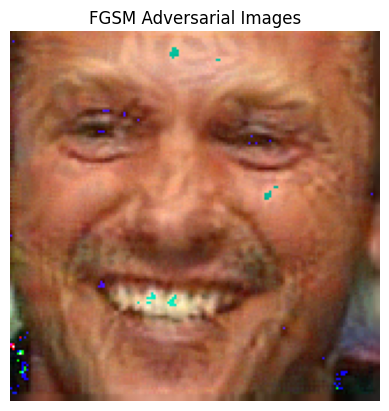

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Supponiamo che test_images_adv sia un array numpy con forma (1, 3, 160, 160)
# Rimuoviamo la dimensione batch extra
test_images_adv = np.squeeze(test_images_adv, axis=0)  # Ora la forma è (3, 160, 160)

# Trasponiamo l'array per convertirlo nel formato channels-last
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))  # Ora la forma è (160, 160, 3)

# Convertiamo in tipo uint8 se necessario
if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizziamo l'immagine con Matplotlib
plt.imshow(test_images_adv)
plt.title("FGSM Adversarial Images")
plt.axis('off')  # Disabilita gli assi
plt.show()





IDEA: Bloccare solo la massima epsilon e far variare solo le max_iter e gli eps_step.

In [ ]:
# PGD generic Attack for all samples
import os
import re

dataset_dir = "test_set_cropped/" 
eps_step = [0.00002, 0.00005, 0.00007, 0.0002, 0.0005, 0.0007, 0.002, 0.005, 0.007, 0.01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
#eps_range = [0.001, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7] #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).
eps_range = 0.01

accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = eps_range, eps_step=step, targeted=False, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")

# correct_predictions = 0
# total_images = 0
# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

**TARGETED ATTACK**

In [35]:
epsilon = 1
eps_step = 0.1
max_iter = 1 

attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = epsilon, eps_step= eps_step, targeted=True, max_iter = max_iter)

In [ ]:
#PGD specific Attack for single sample

target_class = 10 

batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

print(one_hot_targeted_labels.shape)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)


model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print("Etichetta target:{}".format(LABELS[target_class]))
print(model_predictions)
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

In [36]:
#PGD specific Attack for all samples
import os
import re

dataset_dir = "test_set_cropped_piccolo/" 
#eps_step = [0.0002, 0.0002, 0.0002, 0.001, 0.002, 0.002, 0.01, 0.02, 0.05] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.
eps_step = [0.0002,0.002]
max_iter = [1,2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
#eps_range = [0.001, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7] #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).
eps_range = 0.7

accuracy_misclassified_for_eps = []
accuracy_misclassified_for_max_iter = []
accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_misclassified = 0
total_images = 0

target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])
batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps = eps_range, eps_step=step, targeted=True, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1
                        
                    if etichetta_target in predicted_label:  
                        correct_misclassified = correct_misclassified+1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    accuracy_misclassified = correct_misclassified/total_images
                    print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))
                
                accuracy_misclassified = correct_misclassified/total_images
                accuracy_misclassified_for_eps.append(accuracy_misclassified)
                print("----------- Adversarial Sample misclassificati correttamente: {}% -----------".format((accuracy_misclassified)))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []

        if True:
            accuracy__misclassified_media_per_max_iter = sum(accuracy_misclassified_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_misclassified_for_max_iter.append(accuracy__misclassified_media_per_max_iter)
            print("----------- Accuracy MISCLASSIFIED media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_misclassified_for_max_iter[i]))
            accuracy_misclassified_for_eps = []


        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")


# correct_predictions = 0
# total_images = 0
# target_class = 10
# print("ETICHETTA TARGET: ", LABELS[10])
# batch_size = test_img.shape[0]
# targeted_labels = np.array([target_class] * batch_size)
# one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)

# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

ETICHETTA TARGET:   Aaron_Hernandez
Inizio Attacco PGD NON-TARGETED
**** Attacco con max_iter 1 **** 
**** Attacco con eps:0.7 con step a 0.0002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.624496459960938 e con perturbazione 0.00019256384985055774
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.477907180786133 e con perturbazione 0.00019255444931332022
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.011987686157227 e con perturbazione 0.0001925574179040268
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.64526081085205 e con perturbazione 0.00019255466759204865
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.201183319091797 e con perturbazione 0.00019255338702350855
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.073992729187012 e con perturbazione 0.00019256114319432527
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.62385082244873 e con perturbazione 0.00019256342784501612
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.956990242004395 e con perturbazione 0.00019256648374721408
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.877860069274902 e con perturbazione 0.0001925573596963659
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.00019255913179626482% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.8888888888888888% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 11.713798522949219 e con perturbazione 0.001925696968100965
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.133880615234375 e con perturbazione 0.0019256871892139316
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Qin_Lan con probabilità 9.557074546813965 e con perturbazione 0.0019256907980889082
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 11.546121597290039 e con perturbazione 0.001925688236951828
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.12099838256836 e con perturbazione 0.001925686956383288
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 11.947136878967285 e con perturbazione 0.0019256945233792067
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 12.394708633422852 e con perturbazione 0.0019256965024396777
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 71.42857142857143%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 10.674184799194336 e con perturbazione 0.0019256992964074016
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.105785369873047 e con perturbazione 0.0019256905652582645
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 77.77777777777779%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.0019256923373581634% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.7777777777777778% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 1 sugli adversarial Sample: 0.0010591257345772141\% ----------------
----------- Accuracy media con iterazione 1 sugli adversarial Sample: 0.8333333333333333\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 1 sugli adversarial Sample: 0.0\% ----------------
-------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.525548934936523 e con perturbazione 0.00036978963180445135
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.447824478149414 e con perturbazione 0.0003685738774947822
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.844030380249023 e con perturbazione 0.00036221527261659503
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.392444610595703 e con perturbazione 0.00036759517388418317
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.074150085449219 e con perturbazione 0.0003673844039440155
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.94344711303711 e con perturbazione 0.0003668366698548198
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.494535446166992 e con perturbazione 0.00036704412195831537
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.828234672546387 e con perturbazione 0.0003649822610896081
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.80964469909668 e con perturbazione 0.0003681209054775536
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0003669491464582582% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.8888888888888888% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 10.86684513092041 e con perturbazione 0.0033454580698162317
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 9.641264915466309 e con perturbazione 0.0032446086406707764
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Mai_Phương_Thúy con probabilità 8.751479148864746 e con perturbazione 0.002959980396553874
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 9.610486030578613 e con perturbazione 0.00310289254412055
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 10.887496948242188 e con perturbazione 0.003230649745091796
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 60.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 10.772238731384277 e con perturbazione 0.0032018085476011038
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 10.907533645629883 e con perturbazione 0.0032041037920862436
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 71.42857142857143%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 9.52874755859375 e con perturbazione 0.003085931297391653
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 62.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 11.130279541015625 e con perturbazione 0.0032271139789372683
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.0031780607791410554% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.6666666666666666% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 2 sugli adversarial Sample: 0.0017725049627996569\% ----------------
----------- Accuracy media con iterazione 2 sugli adversarial Sample: 0.7777777777777777\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 2 sugli adversarial Sample: 0.0\% ----------------
-------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.233460426330566 e con perturbazione 0.0009002640726976097
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.365880966186523 e con perturbazione 0.0008897681254893541
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 10.22774887084961 e con perturbazione 0.0008581688744015992
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 12.663758277893066 e con perturbazione 0.0008847329881973565
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.699227333068848 e con perturbazione 0.0008925177389755845
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.558758735656738 e con perturbazione 0.0008884602575562894
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.075329780578613 e con perturbazione 0.0008859499357640743
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.419236183166504 e con perturbazione 0.0008808440761640668
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.576398849487305 e con perturbazione 0.0008884893613867462
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0008854661589591868% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.8888888888888888% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 9.385053634643555 e con perturbazione 0.0072548468597233295
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  J._J._Watt con probabilità 9.374737739562988 e con perturbazione 0.006906532216817141
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Park_Ji-yeon con probabilità 8.610766410827637 e con perturbazione 0.0063079530373215675
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Gloria_Hunniford con probabilità 9.213035583496094 e con perturbazione 0.006548205390572548
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 9.043011665344238 e con perturbazione 0.00677533308044076
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 8.547547340393066 e con perturbazione 0.006757651921361685
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 8.696069717407227 e con perturbazione 0.0065552121959626675
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 42.857142857142854%


Etichetta corretta: Christopher_Nolan
Predetto  Don_Mattingly con probabilità 8.938997268676758 e con perturbazione 0.006556002888828516
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 37.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 12.940411567687988 e con perturbazione 0.006814409047365189
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.006719571848710378% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.3333333333333333% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 5 sugli adversarial Sample: 0.003802519003834782\% ----------------
----------- Accuracy media con iterazione 5 sugli adversarial Sample: 0.611111111111111\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 5 sugli adversarial Sample: 0.0\% ----------------
-------------------------------------------------------------------------------------------------------

Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.041487693786621 e con perturbazione 0.0012414194643497467
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.299530029296875 e con perturbazione 0.0012227041879668832
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 9.798932075500488 e con perturbazione 0.0011665180791169405
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 12.219887733459473 e con perturbazione 0.001209998270496726
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 12.43992805480957 e con perturbazione 0.0012263270327821374
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 12.325526237487793 e con perturbazione 0.0012184862280264497
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 12.776395797729492 e con perturbazione 0.0012154795695096254
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 11.142376899719238 e con perturbazione 0.001206394867040217
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.406646728515625 e con perturbazione 0.0012219460913911462
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.0002 equivale a 0.0012143637545199858% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.0002 equivale a 0.8888888888888888% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
**** Attacco con eps:0.7 con step a 0.002 ****


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 8.55380630493164 e con perturbazione 0.009248747490346432
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


Etichetta corretta: Antonio_Cassano
Predetto  Aaron_Hernandez con probabilità 9.24515151977539 e con perturbazione 0.00870292354375124
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


Etichetta corretta: Ariana_Grande
Predetto  Aaron_Hernandez con probabilità 8.852758407592773 e con perturbazione 0.008067630231380463
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 33.33333333333333%


Etichetta corretta: Ashley_Scott
Predetto  Aaron_Hernandez con probabilità 9.67587947845459 e con perturbazione 0.008425431326031685
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 25.0%


Etichetta corretta: Boris_Johnson
Predetto  Vladimir_Petković con probabilità 8.49439525604248 e con perturbazione 0.008581671863794327
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 20.0%


Etichetta corretta: Brad_Pitt
Predetto  Sergio_Goyri con probabilità 8.982304573059082 e con perturbazione 0.008608371019363403
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 16.666666666666664%


Etichetta corretta: Christian_De_Sica
Predetto  Aaron_Hernandez con probabilità 10.330480575561523 e con perturbazione 0.008369944989681244
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 14.285714285714285%


Etichetta corretta: Christopher_Nolan
Predetto  Aaron_Hernandez con probabilità 12.09616470336914 e con perturbazione 0.008310322649776936
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 12.5%


Etichetta corretta: Cristiano_Ronaldo
Predetto  Aaron_Hernandez con probabilità 15.280435562133789 e con perturbazione 0.008631637319922447
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 11.11111111111111%
----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: 0.002 equivale a 0.008549631159338687% ----------------
----------- Accuracy sugli adversarial Sample per eps_step: 0.002 equivale a 0.1111111111111111% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 7 sugli adversarial Sample: 0.004881997456929336\% ----------------
----------- Accuracy media con iterazione 7 sugli adversarial Sample: 0.5\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 7 sugli adversarial Sample: 0.0\% ----------------
---------------------------------------------------------------------------------------------------------------------

#  **CARLINI WAGNER **ATTACK****

In [ ]:
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod

Il metodo Carlini and Wagner L_0 Attack è un attacco iterativo che mira a trovare un esempio avversario minimizzando il numero di caratteristiche modificate (norma L_0). Ecco una spiegazione dettagliata del metodo e dei suoi parametri:

Metodo Carlini and Wagner L_0 Attack
Parametri del Metodo __init__
classifier (CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE):

Un classificatore addestrato che implementa i metodi per calcolare le perdite e i gradienti delle perdite rispetto agli input.
confidence (float = 0.0):

La fiducia degli esempi avversari: un valore più alto produce esempi che sono più lontani dall'input originale ma classificati con maggiore fiducia come la classe target. Questo parametro bilancia la necessità di modificare l'input originale con la certezza che l'output sia nella classe avversaria desiderata.
targeted (bool = False):

Indica se l'attacco è mirato a una specifica classe (True) o meno (False). In un attacco mirato, l'obiettivo è far classificare l'input avversario come una classe specifica scelta dall'attaccante. In un attacco non mirato, l'obiettivo è semplicemente far classificare l'input in una classe diversa da quella corretta.
learning_rate (float = 0.01):

Il tasso di apprendimento iniziale per l'algoritmo di attacco. Valori più piccoli producono risultati migliori ma convergono più lentamente.
binary_search_steps (int = 10):

Numero di volte in cui regolare la costante con la ricerca binaria (valore positivo). Se binary_search_steps è grande, l'algoritmo non è molto sensibile al valore di initial_const. Questo parametro controlla quante volte la costante di trade-off viene aggiustata per trovare il miglior equilibrio tra la distanza e la fiducia.
max_iter (int = 10):

Il numero massimo di iterazioni per l'attacco.
initial_const (float = 0.01):

La costante di trade-off iniziale c per regolare l'importanza relativa tra la distanza e la fiducia. Se binary_search_steps è grande, il valore iniziale di questa costante non è critico.
mask (ndarray | None = None):

Le caratteristiche iniziali che possono essere modificate dall'algoritmo. Se non specificato, l'algoritmo utilizza l'intero set di caratteristiche. Questo parametro può essere utilizzato per limitare l'attacco a modificare solo determinate parti dell'input.
warm_start (bool = True):

Invece di iniziare la discesa del gradiente in ogni iterazione dall'immagine iniziale, si inizia la discesa del gradiente dalla soluzione trovata nell'iterazione precedente. Questo parametro può accelerare la convergenza.
max_halving (int = 5):

Numero massimo di passi di dimezzamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene dimezzata durante la ricerca di un passo ottimale.
max_doubling (int = 5):

Numero massimo di passi di raddoppiamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene raddoppiata durante la ricerca di un passo ottimale.
batch_size (int = 1):

La dimensione del batch su cui vengono generati i campioni avversari. Questo parametro determina quanti campioni vengono processati contemporaneamente durante l'attacco.

verbose (bool = True):
Mostra barre di avanzamento. Se impostato su True, verranno visualizzati i progressi dell'attacco durante l'esecuzione.

**NON-TARGETED ATTACK**

In [ ]:
#Numero di volte in cui regolare la costante con la ricerca binaria (valore positivo). Se binary_search_steps è grande, l'algoritmo non è molto sensibile al valore di initial_const. Questo parametro controlla quante volte la costante di trade-off viene aggiustata per trovare il miglior equilibrio tra la distanza e la fiducia.
binary_search_steps = 1
#La fiducia degli esempi avversari: un valore più alto produce esempi che sono più lontani dall'input originale ma classificati con maggiore fiducia come la classe target. Questo parametro bilancia la necessità di modificare l'input originale con la certezza che l'output sia nella classe avversaria desiderata.
confidence = 0.5
warm_start = False #Invece di iniziare la discesa del gradiente in ogni iterazione dall'immagine iniziale, si inizia la discesa del gradiente dalla soluzione trovata nell'iterazione precedente. Questo parametro può accelerare la convergenza.
max_iter = 10
learning_rate = 0.01 #Il tasso di apprendimento iniziale per l'algoritmo di attacco. Valori più piccoli producono risultati migliori ma convergono più lentamente.
initial_const = 1000 #La costante di trade-off iniziale c per regolare l'importanza relativa tra la distanza e la fiducia. Se binary_search_steps è grande, il valore iniziale di questa costante non è critico.

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)


In [ ]:
# Carlini Wagner generic attack on single sample

test_images_adv = attack.generate(test_img)

#loss_test, accuracy_test = model.evaluate(test_images_adv, test_labels)
model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img)))
#print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
print(LABELS[target_class])
print(model_predictions)
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

DA ADATTARE ANCORA

In [ ]:
# Carlini Wagner generic attack on all samples
import os
import re

dataset_dir = "test_set_cropped_piccolo/" 
binary_search_steps = 1
confidence = 0.5
max_iter = 10
learning_rate = 0.01
initial_const = 1000

accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco PGD NON-TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for step in eps_step:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,step))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = model.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(step,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(step,final_accuracy))

            #Per ogni epsilon impostata salvo in accuracy plot
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(eps_step) # Calcolo la perturbazione media dopo aver provato tutte le epsilon,quindi la media delle perturbazioni per eps_range
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(eps_step) # Calcolo l'accuracy media dopo aver provato tutte le epsilon,quindi la media dell'accuracy per ogni eps_range
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")


# correct_predictions = 0
# total_images = 0
# for filename in os.listdir(dataset_dir):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         person_path = os.path.join(dataset_dir, filename)
#         print("Immagine:", filename)
#         test_img = load_image(person_path)
#         test_img = test_img.unsqueeze(0)
#         test_img = test_img.numpy()
#         test_images_adv = attack.generate(test_img)
#         model_predictions = model.predict(test_images_adv)
#         correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
#         print("Etichetta corretta:", correct_label)   
#         perturbation = np.mean(np.abs((test_images_adv - test_img)))
#         predicted_label = LABELS[np.array(model_predictions[0].argmax())]
#         print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
#         total_images+=1

#         if predicted_label == correct_label:
#             correct_predictions+=1

#         accuracy = correct_predictions/total_images
#         print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

# if total_images != 0:
#     final_accuracy = correct_predictions/total_images
#     print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

**TARGETED ATTACK**


In [ ]:
binary_search_steps = 1
confidence = 0.5
max_iter = 10
learning_rate = 0.01
initial_const = 1000
target_class = 6

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=True)


In [ ]:
# Carlini Wagner specific attack on single sample


# Trasformazione del dato categorico
targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)

model_predictions = model.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img)))
print('Average perturbation: {:4.2f}'.format(perturbation))
#targeted_attack_loss, targeted_attack_accuracy = model.evaluate(test_images_adv, targeted_labels)
#print('Targeted attack accuracy: {:4.2f}'.format(targeted_attack_accuracy))
print(LABELS[target_class])
print(model_predictions)
predicted_label = LABELS[np.array(model_predictions.argmax())]
print("{} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))

In [ ]:
# Carlini Wagner specific attack on all samples


correct_predictions = 0
total_images = 0
target_class = 10

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)

for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        person_path = os.path.join(dataset_dir, filename)
        print("Immagine:", filename)
        test_img = load_image(person_path)
        test_img = test_img.unsqueeze(0)
        test_img = test_img.numpy()
        test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
        model_predictions = model.predict(test_images_adv)
        correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
        print("Etichetta corretta:", correct_label)   
        perturbation = np.mean(np.abs((test_images_adv - test_img)))
        print('Average perturbation: {:4.2f}'.format(perturbation))
        predicted_label = LABELS[np.array(model_predictions[0].argmax())]
        print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
        
        total_images+=1

        if predicted_label == correct_label:
            correct_predictions+=1

        accuracy = correct_predictions/total_images
        print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

if total_images != 0:
    final_accuracy = correct_predictions/total_images
    print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

# DeepFool

**NON-TARGETED ATTACK**

In [9]:
from art.attacks.evasion import DeepFool

epsilon = 0.05
max_iter = 5

attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

In [14]:
import os
import re

correct_predictions = 0
total_images = 0

dataset_dir = "test_set_cropped"

for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        person_path = os.path.join(dataset_dir, filename)
        print("Immagine:", filename)
        test_img = load_image(person_path)
        test_img = test_img.unsqueeze(0)
        test_img = test_img.numpy()
        test_images_adv = attack.generate(test_img)
        model_predictions = model.predict(test_images_adv)
        correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
        print("Etichetta corretta:", correct_label)   
        perturbation = np.mean(np.abs((test_images_adv - test_img)))
        predicted_label = LABELS[np.array(model_predictions[0].argmax())]
        print("Predetto {} con probabilità {}".format(predicted_label,model_predictions[0][model_predictions.argmax()]))
        total_images+=1

        if predicted_label == correct_label:
            correct_predictions+=1

        accuracy = correct_predictions/total_images
        print("Accuracy sugli adversarial Sample: {}%".format((100-(accuracy*100))))
        

if total_images != 0:
    final_accuracy = correct_predictions/total_images
    print("----------- Accuracy FINALE sugli adversarial Sample: {}\% ----------------".format(final_accuracy))

Immagine: Michael_Phelps_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Michael_Phelps
Predetto  Rick_Perry con probabilità 11.578573226928711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Etichetta corretta: Paola_Barale
Predetto  Ewa_Kasprzyk con probabilità 11.713584899902344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Louis_Gossett_Jr. con probabilità 11.584121704101562
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Etichetta corretta: Max_Pezzali
Predetto  Jean-Louis_Borloo con probabilità 7.99006986618042
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Trey_Songz con probabilità 10.218764305114746
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Ashley_Scott
Predetto  Cerys_Matthews con probabilità 12.948068618774414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Robert_Berić con probabilità 10.216793060302734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Etichetta corretta: Michael_Phelps
Predetto  Michael_Boogerd con probabilità 10.614141464233398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Bill_Belichick con probabilità 9.139281272888184
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Etichetta corretta: Tom_Felton
Predetto  Derren_Brown con probabilità 8.665434837341309
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Karlos_Arguiñano con probabilità 10.348128318786621
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Costa_Cordalis con probabilità 9.43947982788086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Naomi_Watts
Predetto  Ophélie_Winter con probabilità 11.316287994384766
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Jack_Savoretti con probabilità 9.101751327514648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Oliver_Stone con probabilità 10.727664947509766
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Justin_Gaston con probabilità 10.386716842651367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Shauna_Sand con probabilità 11.355182647705078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Haruna_Kojima con probabilità 9.420957565307617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Elisa_Carrió con probabilità 9.158992767333984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Liz_Phair con probabilità 11.482866287231445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Ilary_Blasi con probabilità 10.900406837463379
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Paola_Barale con probabilità 11.113028526306152
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Tim_Cook
Predetto  Volker_Bouffier con probabilità 11.220359802246094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Marco_Fantini
Predetto  Stewart_Downing con probabilità 12.374351501464844
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Pedro_Joaquín_Coldwell con probabilità 12.556032180786133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Alberto_San_Juan con probabilità 10.920860290527344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Loredana_Bertè con probabilità 11.881775856018066
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Thierry_Henry
Predetto  Shanthanu_Bhagyaraj con probabilità 12.398256301879883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Kayky_Brito con probabilità 10.959261894226074
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Marco_Carta
Predetto  Luke_Shaw con probabilità 11.255971908569336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Robert_Pattison
Predetto  Camille_Lacourt con probabilità 11.708595275878906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Ed_Balls con probabilità 11.6368989944458
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Eveline_Widmer-Schlumpf con probabilità 9.516420364379883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Matt_Damon
Predetto  Pavel_Horváth con probabilità 10.124326705932617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Andrea_Pirlo con probabilità 12.469462394714355
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Djimon_Hounsou con probabilità 11.947526931762695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Jack_Mackenroth con probabilità 10.453577041625977
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Aidan_Turner con probabilità 12.6337890625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Eddie_Levert con probabilità 12.618661880493164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Percy_Sledge con probabilità 10.886502265930176
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Gabby_Concepcion con probabilità 10.8970308303833
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Josh_Hartnett con probabilità 11.170760154724121
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Etichetta corretta: Miriam_Leone
Predetto  Stella_Tennant con probabilità 9.43461799621582
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


Etichetta corretta: Frans_Bauer
Predetto  Frans_Bauer con probabilità 9.263675689697266
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Luke_Bryan con probabilità 9.031137466430664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Travis_Scott
Predetto  Didier_Drogba con probabilità 12.814115524291992
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Etichetta corretta: Max_Pezzali
Predetto  Max_Pezzali con probabilità 11.46135425567627
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Russell_Crowe
Predetto  Rafael_Benítez con probabilità 10.937843322753906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Etichetta corretta: Boris_Johnson
Predetto  Miguel_Lifschitz con probabilità 11.169609069824219
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Ottfried_Fischer con probabilità 11.775224685668945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Bobbie_Eakes con probabilità 12.72048568725586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Luca_Toni
Predetto  Antonio_Conte con probabilità 10.57689094543457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Barbara_Boxer con probabilità 11.185333251953125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Jencarlos_Canela con probabilità 8.9847412109375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Kim_Dotcom con probabilità 10.354368209838867
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  John_McAfee con probabilità 8.731821060180664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Ferdi_Tayfur con probabilità 11.202468872070312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Edin_Džeko con probabilità 9.335908889770508
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Timothy_Dalton con probabilità 10.056001663208008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Etichetta corretta: Malika_Ayane
Predetto  Ana_Torroja con probabilità 12.410528182983398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Etichetta corretta: Ice_Cube
Predetto  Mike_Tomlin con probabilità 9.239113807678223
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Radu_Mazăre con probabilità 10.684703826904297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Sophia_Loren
Predetto  Natalie_Imbruglia con probabilità 11.528548240661621
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Jed_Madela con probabilità 9.219858169555664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Luca_Argentero
Predetto  Emre_Altuğ con probabilità 10.26317024230957
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Kourtney_Kardashian con probabilità 9.909271240234375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Thierry_Henry
Predetto  J._B._Smoove con probabilità 9.266803741455078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Enrico_Letta
Predetto  Joe_Girardi con probabilità 12.913982391357422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Roger_Federer
Predetto  Pier_Ferdinando_Casini con probabilità 11.718854904174805
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Sergio_Martínez con probabilità 11.00136947631836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Danny_Elfman con probabilità 11.832979202270508
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Donny_Osmond con probabilità 9.54581069946289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Karlos_Arguiñano con probabilità 11.709278106689453
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Kseniya_Sobchak con probabilità 14.496906280517578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Didier_Deschamps con probabilità 11.936201095581055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Daniela_Santanchè con probabilità 9.31442642211914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Cerys_Matthews con probabilità 10.400458335876465
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Halle_Berry con probabilità 12.18826675415039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Etichetta corretta: Matthew_Perry
Predetto  Bill_Bailey con probabilità 9.587671279907227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Javier_Aguirre con probabilità 10.909408569335938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Joaquín_Almunia con probabilità 10.127911567687988
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Michael_Phelps
Predetto  Frédérick_Bousquet con probabilità 11.790830612182617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Paola_Barale
Predetto  Angham con probabilità 11.271583557128906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Daymond_John con probabilità 9.344766616821289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Marcus_Collins con probabilità 13.198923110961914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Kristanna_Loken con probabilità 11.547515869140625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Bobbie_Eakes con probabilità 12.036584854125977
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Ross_Antony con probabilità 12.155969619750977
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Tom_Felton
Predetto  Johannes_Oerding con probabilità 10.180212020874023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Werner_Schünemann con probabilità 10.192001342773438
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Etichetta corretta: David_Beckham
Predetto  Bernhard_Langer con probabilità 11.526874542236328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Tony_Montana
Predetto  Kamal_Nath con probabilità 12.110711097717285
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Luca_Argentero
Predetto  Gáspár_Laci con probabilità 10.959100723266602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Duško_Vujošević con probabilità 11.914369583129883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Etichetta corretta: Tony_Montana
Predetto  Álex_Lora con probabilità 11.733776092529297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Oussama_Assaidi con probabilità 10.63899040222168
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Ariana_Grande
Predetto  Elham_Hamidi con probabilità 10.11294937133789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Colin_Farrell con probabilità 12.157573699951172
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Rick_Gervais con probabilità 11.716514587402344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Ajda_Pekkan con probabilità 11.591285705566406
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Miriam_Leone
Predetto  Charlotte_Church con probabilità 11.011957168579102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Frans_Bauer
Predetto  Matthew_Tuck con probabilità 11.81847095489502
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Michael_Jackson
Predetto  Bria_Murphy con probabilità 11.030298233032227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Édouard_Baer con probabilità 11.20291519165039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Brittany_Daniel con probabilità 11.561009407043457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Dick_Wolf con probabilità 10.49365234375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Matteo_Darmian
Predetto  James_Franco con probabilità 12.795740127563477
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Willa_Holland
Predetto  Alessandra_Mastronardi con probabilità 10.016135215759277
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Boris_Johnson
Predetto  Hans_Vestberg con probabilità 11.786693572998047
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  David_Gallop con probabilità 10.625865936279297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Jerry_Rawlings con probabilità 10.042474746704102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Gervinho
Predetto  Djibril_Cissé con probabilità 9.382147789001465
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  François-Xavier_Demaison con probabilità 10.484367370605469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Joan_Crawford con probabilità 11.652312278747559
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Adam_Nawałka con probabilità 12.508820533752441
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Thierry_Henry
Predetto  Cem_Yılmaz con probabilità 14.047039031982422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Stone_Cold_Steve_Austin con probabilità 10.688993453979492
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Sarah_Hadland con probabilità 10.768065452575684
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Glória_Menezes con probabilità 9.469954490661621
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Matthew_Perry
Predetto  Chris_Hardwick con probabilità 11.268758773803711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Fatih_Terim con probabilità 11.872138977050781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Ranulph_Fiennes con probabilità 9.299787521362305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Michelle_Heaton con probabilità 11.855968475341797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Toshiya_Miura con probabilità 8.197890281677246
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Davina_McCall con probabilità 11.07412338256836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Adam_Sztaba con probabilità 11.97017765045166
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Larry_David con probabilità 10.57443904876709
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Beth_Behrs con probabilità 11.361518859863281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Federica_Nargi
Predetto  Perla_Beltrán con probabilità 10.049747467041016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Brad_Garrett con probabilità 10.891060829162598
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Šárka_Vaňková con probabilità 11.021313667297363
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Mils_Muliaina con probabilità 11.421586990356445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Samantha_Fox con probabilità 11.360095977783203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Daymond_John con probabilità 9.079010009765625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Michael_Phelps
Predetto  Michael_Phelps con probabilità 12.949756622314453
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Carlos_Areces con probabilità 8.131599426269531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Malika_Ayane
Predetto  Adrienne_Bailon con probabilità 11.780009269714355
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Wolfgang_Bahro con probabilità 12.00874137878418
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Nikos_Aliagas con probabilità 9.852741241455078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Brad_Pitt
Predetto  Josh_Hartnett con probabilità 11.7828369140625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Roger_Federer
Predetto  David_Coulthard con probabilità 10.885637283325195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Alejandro_Fernández con probabilità 10.273641586303711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Randy_Orton
Predetto  Jerry_Sandusky con probabilità 11.981264114379883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 10.720880508422852
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Nawal_Al_Zoghbi con probabilità 11.860419273376465
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Ice_Cube
Predetto  Craig_David con probabilità 10.081809997558594
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Sophia_Loren
Predetto  Lil_Kim con probabilità 9.910218238830566
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Mike_Tyson
Predetto  Reggie_Yates con probabilità 10.383356094360352
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Etichetta corretta: Willa_Holland
Predetto  Kerri_Kasem con probabilità 11.108512878417969
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Riccardo_Muti con probabilità 11.386896133422852
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Aritz_Aduriz con probabilità 9.804866790771484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: Ashley_Scott
Predetto  Heather_Mills con probabilità 11.599356651306152
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Sonya_Kraus con probabilità 10.113725662231445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: Naomi_Watts
Predetto  Abbey_Clancy con probabilità 11.416023254394531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Joan_Plaza con probabilità 8.257989883422852
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: Michael_Jackson
Predetto  Rochelle_Aytes con probabilità 11.113373756408691
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Borys_Szyc con probabilità 11.284080505371094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Alan_Mulally con probabilità 9.400839805603027
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Gedeon_Burkhard con probabilità 9.85095500946045
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Jolande_Sap con probabilità 10.72050666809082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Peter_Mandelson con probabilità 11.570365905761719
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Gervinho
Predetto  Dennis_Rodman con probabilità 12.102010726928711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Rick_Scott con probabilità 12.398384094238281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Walid_Jumblatt con probabilità 10.929848670959473
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Etichetta corretta: Zendaya
Predetto  Krisdayanti con probabilità 10.853546142578125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Etichetta corretta: Enrico_Letta
Predetto  Callum_Keith_Rennie con probabilità 10.725605010986328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Mike_Tyson
Predetto  Curtis_Jackson con probabilità 11.916715621948242
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Etichetta corretta: David_Beckham
Predetto  Dani_Sordo con probabilità 9.382620811462402
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Tony_Montana
Predetto  Jorge_Jesus con probabilità 11.734132766723633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Luca_Argentero
Predetto  Michael_Vartan con probabilità 11.576419830322266
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Daniel_Landa con probabilità 11.820682525634766
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Zendaya
Predetto  Erich_Gonzales con probabilità 12.586108207702637
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Nebojša_Čović con probabilità 11.950932502746582
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Etichetta corretta: Russell_Crowe
Predetto  Gerhard_Schröder con probabilità 8.777567863464355
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


Etichetta corretta: Diego_Maradona
Predetto  Jeroen_van_der_Boom con probabilità 10.564774513244629
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Lauris_Reiniks con probabilità 9.350976943969727
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Natasza_Urbańska con probabilità 10.339073181152344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Ariana_Grande
Predetto  Tatjana_Gsell con probabilità 12.563417434692383
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Carlos_Tevez con probabilità 10.620269775390625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Reinhold_Messner con probabilità 11.561169624328613
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Gary_Sinise con probabilità 7.394932746887207
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Thierry_Henry
Predetto  Al_Sharpton con probabilità 11.912517547607422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Randy_Orton
Predetto  Juan_Gil_Navarro con probabilità 13.934160232543945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Richard_Bohringer con probabilità 11.973627090454102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Tim_Cook
Predetto  Tobias_Moretti con probabilità 11.881902694702148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Sergio_Mattarella con probabilità 10.076929092407227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Mike_Tyson
Predetto  Anthony_Ogogo con probabilità 13.659751892089844
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Fernando_Llorente
Predetto  André-Pierre_Gignac con probabilità 10.108673095703125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Allen_Leech con probabilità 11.026358604431152
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Etichetta corretta: Matt_Damon
Predetto  Dan_Carter con probabilità 7.139946460723877
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Marco_Carta
Predetto  Greg_Plitt con probabilità 11.112285614013672
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Robert_Pattison
Predetto  Dick_Rivers con probabilità 10.372589111328125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Brad_Pitt
Predetto  Ronn_Moss con probabilità 10.397546768188477
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Tony_La_Russa con probabilità 9.564155578613281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Etichetta corretta: Tom_Felton
Predetto  Roman_Polko con probabilità 9.218467712402344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Ranulph_Fiennes con probabilità 10.740791320800781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Etichetta corretta: Orlando_Bloom
Predetto  François_Baroin con probabilità 9.810651779174805
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Terry_Wogan con probabilità 10.52652645111084
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Michael_B._Jordan con probabilità 11.418272018432617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Federica_Nargi
Predetto  Federica_Nargi con probabilità 13.236621856689453
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  River_Phoenix con probabilità 12.722728729248047
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Etichetta corretta: Paola_Barale
Predetto  Goga_Sekulić con probabilità 9.777946472167969
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Trey_Songz con probabilità 10.108746528625488
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Xavier_Bettel con probabilità 7.74216365814209
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Luis_Advíncula con probabilità 12.294572830200195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Tim_Cook
Predetto  Robert_Gant con probabilità 10.817854881286621
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Marco_Fantini
Predetto  Eduardo_Verástegui con probabilità 11.687359809875488
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Daniela_Santanchè con probabilità 10.961484909057617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Nancy_Pelosi con probabilità 9.498434066772461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Nükhet_Duru con probabilità 11.279884338378906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Jenny_Berggren con probabilità 11.87533950805664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Galilea_Montijo con probabilità 11.211806297302246
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Viktor_Yushchenko con probabilità 10.449461936950684
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Deddy_Mizwar con probabilità 10.910560607910156
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Viktor_Yanukovych con probabilità 9.091249465942383
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Naomi_Watts
Predetto  Elizabeth_Hurley con probabilità 11.479738235473633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Diego_Maradona
Predetto  Óscar_Jaenada con probabilità 12.737991333007812
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Barbara_Boxer con probabilità 12.222808837890625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Luca_Toni
Predetto  Clive_Standen con probabilità 11.703069686889648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Ece_Erken con probabilità 12.60018539428711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Mitchell_Johnson con probabilità 11.36515998840332
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Marco_Giallini con probabilità 13.223845481872559
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Ricardo_Ferretti con probabilità 11.764657974243164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Zendaya
Predetto  Jessica_Burciaga con probabilità 10.295795440673828
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Enrico_Letta
Predetto  Matze_Knop con probabilità 11.040801048278809
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Christoph_M._Ohrt con probabilità 11.44538688659668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Tomi_Joutsen con probabilità 11.860509872436523
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Karim_Benzema con probabilità 11.843099594116211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Russell_Westbrook con probabilità 12.156193733215332
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Dan_Lauria con probabilità 8.331241607666016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Don_Diamont con probabilità 12.402631759643555
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Michu con probabilità 10.151373863220215
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Lynda_Lemay con probabilità 9.581666946411133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Jacques_Rogge con probabilità 8.232071876525879
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Etichetta corretta: Boris_Johnson
Predetto  Uto_Ughi con probabilità 9.615777969360352
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Travis_Scott
Predetto  Mekhi_Phifer con probabilità 11.814214706420898
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Etichetta corretta: Max_Pezzali
Predetto  Anthony_Hopkins con probabilità 9.93770980834961
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Etichetta corretta: Russell_Crowe
Predetto  Daniel_Schuhmacher con probabilità 10.169977188110352
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Ashley_Scott
Predetto  Ophélie_Winter con probabilità 13.004709243774414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Clemens_Schick con probabilità 7.941390514373779
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Jari_Sillanpää con probabilità 10.82889461517334
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Russell_Howard con probabilità 10.426277160644531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Amit_Sadh con probabilità 9.535909652709961
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Edgar_Davids con probabilità 13.189197540283203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Clifton_Collins_Jr. con probabilità 9.822210311889648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Leanne_Wood con probabilità 11.346738815307617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Deborah_Voigt con probabilità 12.38023567199707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Adam_Darski con probabilità 8.207269668579102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Etichetta corretta: Michael_Jackson
Predetto  Tito_Jackson con probabilità 9.752403259277344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Etichetta corretta: Frans_Bauer
Predetto  Tony_Carreira con probabilità 10.406532287597656
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Henri_Leconte con probabilità 9.246698379516602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Miriam_Leone
Predetto  Suhasini_Maniratnam con probabilità 11.184100151062012
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Daniel_Sturridge con probabilità 13.32492733001709
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Etichetta corretta: Boris_Johnson
Predetto  Winfried_Schäfer con probabilità 9.18591594696045
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Etichetta corretta: Russell_Crowe
Predetto  Zdeněk_Troška con probabilità 9.163196563720703
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Julia_Ormond con probabilità 10.996857643127441
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Ashley_Scott
Predetto  Vanessa_Hessler con probabilità 13.831120491027832
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Damián_Alcázar con probabilità 11.771125793457031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Matteo_Salvini
Predetto  John_Torode con probabilità 9.947729110717773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Diego_Maradona
Predetto  Vivek_Oberoi con probabilità 13.255138397216797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Catherine_Oxenberg con probabilità 11.191108703613281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Johan_Bruyneel con probabilità 10.228652000427246
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Luca_Toni
Predetto  Almir_Sater con probabilità 10.848581314086914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Kasia_Kowalska con probabilità 10.540495872497559
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Arielle_Kebbel con probabilità 10.389333724975586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Mitchell_Johnson con probabilità 11.100374221801758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Günter_Verheugen con probabilità 11.552433013916016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Greg_Inglis con probabilità 11.069026947021484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Randy_Orton
Predetto  Devon_Sawa con probabilità 11.366168022155762
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Radu_Mazăre con probabilità 13.005009651184082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Federica_Nargi
Predetto  Nancy_DellOlio con probabilità 12.112751960754395
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Radu_Mazăre con probabilità 11.876326560974121
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Tony_Montana
Predetto  Toto_Wolff con probabilità 11.431598663330078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Luca_Argentero
Predetto  Christoph_M._Ohrt con probabilità 11.212308883666992
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: David_Beckham
Predetto  Tony_McCoy con probabilità 10.281089782714844
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Pippa_Middleton con probabilità 12.75491714477539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Brian_McKnight con probabilità 11.51762580871582
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Etichetta corretta: Paola_Barale
Predetto  Goga_Sekulić con probabilità 10.332889556884766
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Henrique_Meirelles con probabilità 11.076251983642578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Sergio_Dalma con probabilità 9.881370544433594
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Etichetta corretta: Tom_Felton
Predetto  Clayne_Crawford con probabilità 8.378658294677734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Federica_Nargi
Predetto  Katie_Price con probabilità 11.654491424560547
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Lorraine_Kelly con probabilità 11.881925582885742
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Fat_Joe con probabilità 9.662040710449219
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Shin_Hyun-joon con probabilità 9.723739624023438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Ezio_Greggio
Predetto  François_Bayrou con probabilità 12.215230941772461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Aygun_Kazimova con probabilità 11.28111457824707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Mohanlal con probabilità 9.89665412902832
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Frédérick_Bousquet con probabilità 10.745193481445312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Uwe_Ochsenknecht con probabilità 8.743368148803711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Etichetta corretta: Marco_Fantini
Predetto  Gabriel_Aubry con probabilità 11.2444486618042
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Rick_Gervais con probabilità 12.825644493103027
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Matthew_Perry
Predetto  Antonio_Cañizares_Llovera con probabilità 9.90266227722168
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Seka_Aleksić con probabilità 12.190814018249512
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Sadie_Frost con probabilità 10.442743301391602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Joni_Mitchell con probabilità 9.535856246948242
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Francesco_Guidolin con probabilità 11.1007661819458
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Wolfgang_Kubicki con probabilità 10.819632530212402
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Sophia_Loren
Predetto  Carolyn_Murphy con probabilità 12.861629486083984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Miriam_Leone
Predetto  Carolyn_Murphy con probabilità 11.5069580078125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Terry_Wogan con probabilità 12.608405113220215
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Petar_Grašo con probabilità 10.858341217041016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Petter_Northug con probabilità 9.279709815979004
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Thierry_Henry
Predetto  Ryan_Bertrand con probabilità 10.947385787963867
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Marco_Carta
Predetto  Justin_Gaston con probabilità 10.689085006713867
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Robert_Pattison
Predetto  Bastian_Pastewka con probabilità 11.256135940551758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Etichetta corretta: Brad_Pitt
Predetto  Jackson_Browne con probabilità 11.213079452514648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Tony_La_Russa con probabilità 10.42453384399414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Fernando_Llorente
Predetto  T._R._Knight con probabilità 12.085907936096191
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Katja_Kipping con probabilità 10.983339309692383
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Matt_Damon
Predetto  Fat_Joe con probabilità 10.837890625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Essaïd_Belkalem con probabilità 9.897886276245117
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Enrico_Letta
Predetto  Antonio_María_Rouco_Varela con probabilità 9.680042266845703
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  François_Cluzet con probabilità 12.221060752868652
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Zendaya
Predetto  Arlenis_Sosa con probabilità 10.420282363891602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Tony_Montana
Predetto  Toto_Wolff con probabilità 10.193290710449219
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Luca_Argentero
Predetto  Kenan_İmirzalıoğlu con probabilità 13.621442794799805
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Jean-Pierre_Darroussin con probabilità 11.210495948791504
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: David_Beckham
Predetto  Eric_Martsolf con probabilità 12.372955322265625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Scott_Parker con probabilità 11.322949409484863
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Paweł_Deląg con probabilità 11.31181812286377
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Krzysztof_Hołowczyc con probabilità 9.418550491333008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Alicia_Sánchez-Camacho con probabilità 8.323917388916016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Luca_Toni
Predetto  Jordi_Mollà con probabilità 11.589397430419922
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Lee_Ann_Womack con probabilità 12.778539657592773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Michael_Jackson
Predetto  Krisdayanti con probabilità 13.718314170837402
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Giovanna_Antonelli con probabilità 11.273077011108398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Trey_Hardee con probabilità 11.18595027923584
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Julio_Iglesias_Jr. con probabilità 11.028203964233398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Willa_Holland
Predetto  Casey_LaBow con probabilità 12.034799575805664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Gökhan_Özen con probabilità 11.328855514526367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Gervinho
Predetto  Kerry_Von_Erich con probabilità 10.220831871032715
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Sushil_Koirala con probabilità 12.608109474182129
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Donald_Cerrone con probabilità 9.922816276550293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Gökhan_Özen con probabilità 9.792264938354492
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Seda_Sayan con probabilità 9.71401596069336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Joanna_Kluzik-Rostkowska con probabilità 10.874824523925781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Tobias_Moretti con probabilità 11.609960556030273
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Etichetta corretta: Malika_Ayane
Predetto  Selma_Bajrami con probabilità 9.86507797241211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Mirko_Vučinić con probabilità 11.612977027893066
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Etichetta corretta: Matt_Damon
Predetto  Channing_Tatum con probabilità 9.040106773376465
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Nina_Seničar con probabilità 11.085773468017578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Erdoğan_Atalay con probabilità 12.763654708862305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Etichetta corretta: Sophia_Loren
Predetto  Adelina_Ismajli con probabilità 9.579904556274414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Mike_Tyson
Predetto  Luciano_Spalletti con probabilità 9.979717254638672
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Paolo_Maldini con probabilità 8.427653312683105
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Alessio_Boni con probabilità 10.629068374633789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Roger_Federer
Predetto  Jeff_Stelling con probabilità 11.226422309875488
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Randy_Orton
Predetto  Bertrand_Piccard con probabilità 11.64352798461914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Daniela_Peštová con probabilità 12.263420104980469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Claudio_Scajola con probabilità 12.96987533569336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Rupert_Everett con probabilità 12.559139251708984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Mario_Van_Peebles con probabilità 12.797706604003906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Rodrigo_Lombardi con probabilità 7.249617576599121
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Enrico_Ruggeri con probabilità 11.194156646728516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Matthew_Perry
Predetto  Radimir_Čačić con probabilità 11.892967224121094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Shannon_Bex con probabilità 11.592050552368164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Georgie_Gardner con probabilità 11.318764686584473
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Kim_Matula con probabilità 12.3006591796875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Tiziano_Ferro con probabilità 12.668584823608398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  apl.de.ap con probabilità 11.198226928710938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Jeff_Stinco con probabilità 9.402839660644531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Ian_McShane con probabilità 10.758333206176758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Dominic_West con probabilità 10.879989624023438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Czeslaw_Mozil con probabilità 9.547403335571289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Claudio_Lotito con probabilità 10.356266021728516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Mariastella_Gelmini con probabilità 11.200363159179688
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Didier_Drogba con probabilità 12.700078964233398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Robert_Maaskant con probabilità 10.990447998046875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Russell_Crowe
Predetto  Dieter_Hallervorden con probabilità 13.361791610717773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Travis_Scott
Predetto  Emile_Heskey con probabilità 12.762775421142578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Max_Pezzali
Predetto  Dieter_Thomas_Kuhn con probabilità 12.158647537231445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Gigi_DAlessio con probabilità 11.84528923034668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Willa_Holland
Predetto  Holly_Weber con probabilità 10.533757209777832
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Bobby_Zamora con probabilità 10.651891708374023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Marco_Giallini con probabilità 8.46053695678711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Michael_Jackson
Predetto  Agustina_Cherri con probabilità 11.075349807739258
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Margrethe_Vestager con probabilità 8.789263725280762
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Abou_Diaby con probabilità 12.486563682556152
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Javier_Bardem con probabilità 8.061506271362305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Adnan_Sami con probabilità 9.367085456848145
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Sebastián_Piñera con probabilità 9.5405855178833
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Hans_Sarpei con probabilità 12.653759956359863
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  David_Villa con probabilità 10.1940336227417
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Ariana_Grande
Predetto  Lisa_Foiles con probabilità 9.691902160644531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Jeremy_Corbyn con probabilità 11.165336608886719
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Gervinho
Predetto  Young_Buck con probabilità 12.063760757446289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Murat_Dalkılıç con probabilità 11.475964546203613
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Tony_Montana
Predetto  Cansel_Elçin con probabilità 9.953351020812988
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Heiner_Lauterbach con probabilità 11.571990966796875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Don_Airey con probabilità 12.389305114746094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Enrico_Letta
Predetto  Orlando_Bloom con probabilità 13.119725227355957
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Zendaya
Predetto  Krisdayanti con probabilità 10.400602340698242
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Indiana_Evans con probabilità 10.355730056762695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Nadine_Morano con probabilità 9.491128921508789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Marti_Pellow con probabilità 10.418258666992188
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Antonio_Banderas con probabilità 11.691137313842773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Anders_Anundsen con probabilità 11.051025390625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Jesse_Palmer con probabilità 11.263664245605469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Ariana_Grande
Predetto  Masuimi_Max con probabilità 11.84827995300293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Bernhard_Langer con probabilità 11.29503059387207
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Majka_Jeżowska con probabilità 11.044073104858398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Matthew_Perry
Predetto  Rafael_Benítez con probabilità 10.504770278930664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Fatih_Terim con probabilità 12.523395538330078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Barbara_dUrso con probabilità 10.093740463256836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Etichetta corretta: Marco_Fantini
Predetto  Marco_Fantini con probabilità 7.681177139282227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Rick_Gervais con probabilità 11.777984619140625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Tim_Cook
Predetto  Grace_Gummer con probabilità 11.55447006225586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Inés_Sastre con probabilità 11.076671600341797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Naomi_Watts
Predetto  Kristanna_Loken con probabilità 11.418794631958008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Mimi_Rogers con probabilità 11.716354370117188
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Corey_Haim con probabilità 10.60715103149414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Brant_Daugherty con probabilità 11.65496826171875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Vicente_Fox con probabilità 9.85832405090332
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Ed_Rendell con probabilità 12.466182708740234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Bodo_Ramelow con probabilità 12.526327133178711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Werner_Schünemann con probabilità 11.369035720825195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Hank_von_Helvete con probabilità 8.989273071289062
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Emmanuel_Emenike con probabilità 12.876480102539062
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Michael_Phelps
Predetto  Grégory_Coupet con probabilità 14.772554397583008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Piotr_Adamczyk con probabilità 8.614855766296387
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Andre_Berto con probabilità 8.122148513793945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Lorrie_Morgan con probabilità 12.293188095092773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Samy_Naceri con probabilità 11.038740158081055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Tom_Berenger con probabilità 8.609938621520996
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Etichetta corretta: Malika_Ayane
Predetto  Tatjana_Gsell con probabilità 9.641700744628906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Marco_Carta
Predetto  David_Bisbal con probabilità 10.594188690185547
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Robert_Pattison
Predetto  Marco_Mengoni con probabilità 12.622884750366211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Nino_Frassica con probabilità 11.646993637084961
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Marek_Jankulovski con probabilità 10.542325973510742
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Matt_Damon con probabilità 10.269062042236328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Randy_Orton
Predetto  Kim_Dotcom con probabilità 12.744491577148438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Serdar_Ortaç con probabilità 7.909030914306641
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Roger_Federer
Predetto  Daniel_Pancu con probabilità 11.07919692993164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Mike_Tyson
Predetto  Ronnie_Coleman con probabilità 11.488801002502441
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Etichetta corretta: Ice_Cube
Predetto  Ice_Cube con probabilità 11.394840240478516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Donatella_Versace con probabilità 9.7269287109375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Mike_Huckabee con probabilità 9.750596046447754
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Camille_Lacourt con probabilità 9.40489387512207
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Diego_Maradona
Predetto  Hyun_Bin con probabilità 10.687616348266602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Cassie_Steele con probabilità 11.421916007995605
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Olcay_Şahan con probabilità 11.569206237792969
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Diego_Maradona
Predetto  Camilo_Sesto con probabilità 12.314095497131348
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Robert_Makłowicz con probabilità 11.637271881103516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Ariana_Grande
Predetto  Ngo_Thanh_Van con probabilità 12.106555938720703
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Zoran_Milinković con probabilità 11.918503761291504
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Ignazio_La_Russa con probabilità 10.668304443359375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Jeroen_van_der_Boom con probabilità 10.16671085357666
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Don_Airey con probabilità 9.848920822143555
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Luis_Advíncula con probabilità 11.84935474395752
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Pete_Doherty con probabilità 7.169424057006836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Sam_Sorbo con probabilità 9.235631942749023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Al_Jarreau con probabilità 10.011371612548828
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Helmut_Kohl con probabilità 12.07818603515625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Brad_Pitt
Predetto  Jürgen_von_der_Lippe con probabilità 8.21031379699707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Gervinho
Predetto  Dennis_Rodman con probabilità 11.100664138793945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Ashley_Scott
Predetto  Małgorzata_Foremniak con probabilità 11.552114486694336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Alejandro_Fernández con probabilità 7.8905720710754395
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Russell_Crowe
Predetto  Kyle_Chandler con probabilità 11.012758255004883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Travis_Scott
Predetto  Urby_Emanuelson con probabilità 11.6906156539917
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Max_Pezzali
Predetto  Alain_Juppé con probabilità 11.0653076171875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Etichetta corretta: Boris_Johnson
Predetto  Jim_McElwain con probabilità 9.8572416305542
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Big_Tigger con probabilità 10.295709609985352
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Etichetta corretta: Willa_Holland
Predetto  Jennifer_Hawkins con probabilità 12.35417366027832
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Stephen_Mulhern con probabilità 8.108776092529297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Miriam_Leone
Predetto  Leonora_Jakupi con probabilità 11.607961654663086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Philipp_Petzschner con probabilità 9.91508674621582
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Jamie_Hince con probabilità 8.107027053833008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Frans_Bauer
Predetto  Rick_Gervais con probabilità 11.037918090820312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Boris_Diaw con probabilità 12.819454193115234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Thierry_Henry
Predetto  Michel_Martelly con probabilità 8.981964111328125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Kayky_Brito con probabilità 10.032308578491211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Roger_Federer
Predetto  David_Coulthard con probabilità 10.714798927307129
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


Etichetta corretta: Ice_Cube
Predetto  Ice_Cube con probabilità 9.991205215454102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Christian_Clavier con probabilità 11.31908130645752
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Mike_Huckabee con probabilità 10.251825332641602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Barbora_Špotáková con probabilità 9.01783275604248
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Matt_Damon
Predetto  Andreas_Lundstedt con probabilità 10.097655296325684
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Kenny_Dalglish con probabilità 12.610159873962402
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Ian_McShane con probabilità 10.487545013427734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Malika_Ayane
Predetto  Pippa_Middleton con probabilità 12.136362075805664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Brad_Pitt
Predetto  Robert_Redford con probabilità 11.307939529418945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Etichetta corretta: Marco_Carta
Predetto  Shannon_Leto con probabilità 10.629335403442383
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Etichetta corretta: Robert_Pattison
Predetto  Taylor_York con probabilità 11.009956359863281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Philipp_Lahm con probabilità 13.478784561157227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Federica_Nargi
Predetto  Sabrina_Setlur con probabilità 10.735286712646484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Jimmy_Floyd_Hasselbaink con probabilità 11.781152725219727
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Benjamin_Castaldi con probabilità 9.26499080657959
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Etichetta corretta: Tom_Felton
Predetto  Gaby_Köster con probabilità 10.775518417358398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Louis_Gossett_Jr. con probabilità 12.457265853881836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Paola_Barale
Predetto  Nancy_Sorrell con probabilità 10.542640686035156
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Mónica_Noguera con probabilità 11.295209884643555
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  César_Luis_Menotti con probabilità 12.524980545043945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Goga_Sekulić con probabilità 13.60010814666748
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Annika_Jankell con probabilità 11.304561614990234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Britt_Ekland con probabilità 10.125497817993164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Etichetta corretta: Marco_Fantini
Predetto  Laurent_Koscielny con probabilità 11.74189567565918
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Tim_Cook
Predetto  George_Strait con probabilità 10.26760196685791
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Etichetta corretta: Naomi_Watts
Predetto  Sharon_Stone con probabilità 11.018372535705566
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Xavi con probabilità 9.142167091369629
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Ed_Balls con probabilità 8.95977783203125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Pedro_Passos_Coelho con probabilità 9.880425453186035
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Channing_Tatum con probabilità 11.282116889953613
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Heiner_Brand con probabilità 10.887063980102539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Dina_Lohan con probabilità 12.88967514038086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Malika_Ayane
Predetto  Malika_Ayane con probabilità 11.285436630249023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Michèle_Delaunay con probabilità 11.057845115661621
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Giancarlo_Stanton con probabilità 7.830447196960449
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Etichetta corretta: Brad_Pitt
Predetto  Michael_Mronz con probabilità 9.429341316223145
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Alex_Ebert con probabilità 12.626209259033203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Roman_Neustädter con probabilità 10.365854263305664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Roger_Federer
Predetto  Matjaž_Kek con probabilità 10.526159286499023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Etichetta corretta: Randy_Orton
Predetto  Cezary_Pazura con probabilità 9.995331764221191
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Ivan_Koloff con probabilità 10.838897705078125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Etichetta corretta: Marco_Fantini
Predetto  Jake_Owen con probabilità 11.168134689331055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Billy_Ray_Cyrus con probabilità 10.362601280212402
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Mike_Tyson
Predetto  Doc_Rivers con probabilità 9.474845886230469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


Etichetta corretta: Sophia_Loren
Predetto  Fabiola_Campomanes con probabilità 10.758736610412598
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Etichetta corretta: Ice_Cube
Predetto  Ice_Cube con probabilità 9.803937911987305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Anthony_Hopkins con probabilità 11.217273712158203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Demián_Bichir con probabilità 10.257389068603516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Etichetta corretta: Matthew_Perry
Predetto  Uri_Geller con probabilità 11.53117847442627
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Tony_McCoy con probabilità 11.819623947143555
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Wendie_Malick con probabilità 12.077740669250488
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Daniela_Santanchè con probabilità 9.241920471191406
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Sylvie_van_der_Vaart con probabilità 10.491206169128418
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Hor_Namhong con probabilità 11.564863204956055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Nico_Hülkenberg con probabilità 10.265250205993652
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Aygun_Kazimova con probabilità 11.150652885437012
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Christoph_M._Ohrt con probabilità 10.517202377319336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  DeMar_DeRozan con probabilità 10.301216125488281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Gustavo_Matosas con probabilità 10.54041862487793
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Etichetta corretta: Federica_Nargi
Predetto  Fanny_Cadeo con probabilità 12.301446914672852
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Marco_Carta
Predetto  Tiziano_Ferro con probabilità 11.226690292358398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Diana_Haddad con probabilità 11.64889144897461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Jean-Michel_Baylet con probabilità 11.715400695800781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Natasha_St-Pier con probabilità 11.916742324829102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Kevin_Prince con probabilità 13.00870132446289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Carlos_Areces con probabilità 9.835880279541016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  apl.de.ap con probabilità 9.641819953918457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Enrico_Letta
Predetto  Roberto_Vecchioni con probabilità 12.156495094299316
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


Etichetta corretta: Zendaya
Predetto  Sam_Pinto con probabilità 9.401647567749023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Giampiero_Ventura con probabilità 10.60306453704834
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Alfredo_Pérez_Rubalcaba con probabilità 11.607732772827148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Etichetta corretta: Tony_Montana
Predetto  Tim_Roth con probabilità 12.119837760925293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Luca_Argentero
Predetto  Sean_Gunn con probabilità 11.002697944641113
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: David_Beckham
Predetto  Kevin_Pietersen con probabilità 9.237627029418945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Florent_Pagny con probabilità 12.18320083618164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Diego_Maradona
Predetto  Russell_Brand con probabilità 10.55433177947998
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Chris_Christie con probabilità 9.562843322753906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Edoardo_Leo
Predetto  David_Garrett con probabilità 10.921125411987305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Uri_Geller con probabilità 11.583954811096191
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Ariana_Grande
Predetto  Lenka_Dusilová con probabilità 12.163593292236328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Arthur_Sinodinos con probabilità 11.256489753723145
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Etichetta corretta: Willa_Holland
Predetto  Kerri_Kasem con probabilità 10.532449722290039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Ashley_Scott
Predetto  Małgorzata_Foremniak con probabilità 12.879487037658691
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Lane_Garrison con probabilità 12.227485656738281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Etichetta corretta: Michael_Jackson
Predetto  Mireille_Mathieu con probabilità 10.449563980102539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Roger_Allam con probabilità 10.898098945617676
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Benita_Ferrero-Waldner con probabilità 10.595067024230957
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Saïd_Taghmaoui con probabilità 12.109152793884277
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Matt_Damon
Predetto  Clayne_Crawford con probabilità 11.246252059936523
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Lluís_Llach con probabilità 8.334288597106934
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Van_Hansis con probabilità 10.391164779663086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Joanna_Kluzik-Rostkowska con probabilità 9.298772811889648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Gervinho
Predetto  Daniel_Sturridge con probabilità 11.83254623413086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Barbara_dUrso con probabilità 10.348161697387695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Mattia_Destro con probabilità 11.512931823730469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Narendra_Modi con probabilità 10.382206916809082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Rupert_Everett con probabilità 11.15855598449707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  François_Cluzet con probabilità 10.486330032348633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Bernard_Hill con probabilità 10.306089401245117
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Federica_Nargi
Predetto  Songül_Öden con probabilità 11.259592056274414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Lennox_Lewis con probabilità 10.29078197479248
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Larry_David con probabilità 9.881266593933105
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Gary_Cahill con probabilità 13.38016128540039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Steve_Komphela con probabilità 11.1353759765625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Álex_Rodríguez con probabilità 9.740900993347168
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  apl.de.ap con probabilità 10.50850772857666
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Marco_Fantini
Predetto  Yusuf_Güney con probabilità 11.460626602172852
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Tim_Cook
Predetto  Benjamin_Castaldi con probabilità 11.076326370239258
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Eva_Herman con probabilità 12.27923583984375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Naomi_Watts con probabilità 10.184139251708984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Joely_Fisher con probabilità 11.45676040649414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Katie_Chonacas con probabilità 7.940202236175537
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Iva_Janžurová con probabilità 10.880472183227539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Aburizal_Bakrie con probabilità 12.270797729492188
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Marcelo_Tinelli con probabilità 11.157468795776367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Gimena_Accardi con probabilità 13.918027877807617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Naomi_Watts
Predetto  Giovanna_Ewbank con probabilità 11.009129524230957
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Carlos_Queiroz con probabilità 9.530259132385254
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Fabian_Basabe con probabilità 8.805072784423828
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Randy_Orton
Predetto  Pat_Cash con probabilità 11.096898078918457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Peter_Harry_Carstensen con probabilità 10.828638076782227
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Mike_Tyson
Predetto  Marion_Barry con probabilità 12.340036392211914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Maciej_Zakoscielny con probabilità 8.708953857421875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Clemens_Schick con probabilità 10.245511054992676
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Etichetta corretta: Matt_Damon
Predetto  John_C._Reilly con probabilità 9.765507698059082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Marit_Bjørgen con probabilità 12.06007194519043
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Etichetta corretta: Brad_Pitt
Predetto  Dalton_McGuinty con probabilità 8.423300743103027
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Robert_Pattison
Predetto  David_Rath con probabilità 10.194412231445312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Marco_Carta
Predetto  Wesley_Sneijder con probabilità 11.536012649536133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Kamal_Haasan con probabilità 9.827221870422363
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Zoran_Kesić con probabilità 8.333659172058105
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Rahul_Bose con probabilità 9.78356647491455
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Biz_Markie con probabilità 12.508079528808594
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Diego_Hypólito con probabilità 11.574823379516602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Ashley_Scott
Predetto  Dina_Lohan con probabilità 13.225691795349121
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


Etichetta corretta: Russell_Crowe
Predetto  James_Van_Der_Beek con probabilità 9.710620880126953
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Etichetta corretta: Max_Pezzali
Predetto  Polo_Hofer con probabilità 9.782951354980469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Travis_Scott
Predetto  John_Salley con probabilità 10.698256492614746
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Etichetta corretta: Frans_Bauer
Predetto  Marco_Tronchetti_Provera con probabilità 11.716621398925781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Kateřina_Brožová con probabilità 11.647595405578613
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Robert_Knepper con probabilità 11.765514373779297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Miriam_Leone
Predetto  Isabeli_Fontana con probabilità 11.076555252075195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Jamie_Campbell_Bower con probabilità 11.54989242553711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Luca_Toni
Predetto  Milan_Bandić con probabilità 9.662065505981445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Diego_Maradona
Predetto  Francesco_Pannofino con probabilità 10.878776550292969
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Melissa_Rivers con probabilità 12.048531532287598
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Lali_Espósito con probabilità 11.233945846557617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Kamal_Haasan con probabilità 11.682363510131836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Kevin_Costner con probabilità 10.587231636047363
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Enrico_Letta
Predetto  Davide_Ballardini con probabilità 11.29775333404541
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Etichetta corretta: Zendaya
Predetto  Taís_Araújo con probabilità 9.328241348266602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Carlos_Areces con probabilità 8.21031379699707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Claudio_Bisio con probabilità 9.787576675415039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Jean-Pierre_Coffe con probabilità 10.795225143432617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Kabir_Bedi con probabilità 12.077707290649414
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Bernard_Hill con probabilità 12.298431396484375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Lauren_Pope con probabilità 11.80914306640625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Fethullah_Gülen con probabilità 10.988922119140625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Thierry_Henry
Predetto  Sidney_Sam con probabilità 12.440816879272461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Enrico_Ruggeri con probabilità 11.430893898010254
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  K-Maro con probabilità 9.732870101928711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Etichetta corretta: Robert_Pattison
Predetto  Luis_Tosar con probabilità 10.959676742553711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Marco_Carta
Predetto  Steven_Finn con probabilità 10.832484245300293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Michael_Häupl con probabilità 10.432933807373047
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Brad_Pitt
Predetto  Florent_Pagny con probabilità 10.53423023223877
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Dominic_West con probabilità 8.956904411315918
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


Etichetta corretta: Matt_Damon
Predetto  Ville_Haapasalo con probabilità 9.019393920898438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Henry_Rollins con probabilità 10.888492584228516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Guy_Berryman con probabilità 13.227392196655273
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Gaël_Monfils con probabilità 11.443267822265625
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Etichetta corretta: Paola_Barale
Predetto  Giovanna_Ewbank con probabilità 13.221939086914062
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Michael_Phelps
Predetto  Barry_Sloane con probabilità 9.494871139526367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Federica_Nargi
Predetto  Yolanthe_Sneijder-Cabau con probabilità 10.990972518920898
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Antonio_Cassano
Predetto  David_Hellenius con probabilità 10.126838684082031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Nigel_de_Jong con probabilità 12.381380081176758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Martin_ONeill con probabilità 9.863998413085938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Etichetta corretta: Tom_Felton
Predetto  Till_Brönner con probabilità 10.367411613464355
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Etichetta corretta: Matthew_Perry
Predetto  Héctor_Barberá con probabilità 9.346675872802734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Rubén_Omar_Romano con probabilità 8.919755935668945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Etichetta corretta: Naomi_Watts
Predetto  Rachel_Reynolds con probabilità 10.840681076049805
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Sunny_Deol con probabilità 12.336597442626953
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Deddy_Mizwar con probabilità 11.7715482711792
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Sarah_Jessica_Parker con probabilità 10.382844924926758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Viktor_Yushchenko con probabilità 11.08851432800293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Jonathan_Meyers con probabilità 11.5499267578125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Abbey_Clancy con probabilità 12.580144882202148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Amare_Stoudemire con probabilità 10.223487854003906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Ana_Torroja con probabilità 11.343467712402344
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Etichetta corretta: Marco_Fantini
Predetto  Valerio_Scanu con probabilità 11.251816749572754
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Tim_Cook
Predetto  James_Hird con probabilità 11.23779296875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Antonio_Di_Pietro con probabilità 10.929525375366211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Kristen_Alderson con probabilità 10.872686386108398
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 10.679862022399902
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Gail_Kelly con probabilità 10.847370147705078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Luca_Toni
Predetto  Onur_Kıvrak con probabilità 11.43581485748291
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Ben_Mee con probabilità 10.334593772888184
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Marco_Mengoni
Predetto  La_Fouine con probabilità 11.817924499511719
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Frans_Bauer
Predetto  Jack_McGee con probabilità 10.504993438720703
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Etichetta corretta: Paola_Barale
Predetto  Jodie_Marsh con probabilità 10.869441986083984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Siim_Kallas con probabilità 10.413594245910645
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Jonas_Valančiūnas con probabilità 12.297654151916504
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Catherine_Oxenberg con probabilità 9.05632209777832
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Moussa_Dadis_Camara con probabilità 9.335933685302734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Björn_Dixgård con probabilità 8.344888687133789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Nelson_Évora con probabilità 10.110668182373047
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Etichetta corretta: Miriam_Leone
Predetto  Ivonne_Montero con probabilità 9.060728073120117
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Al_Murray con probabilità 10.364534378051758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Ricardo_Darín con probabilità 9.725197792053223
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Etichetta corretta: Frans_Bauer
Predetto  Michael_Keaton con probabilità 10.452987670898438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Etichetta corretta: Russell_Crowe
Predetto  Biz_Markie con probabilità 8.507868766784668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Ashley_Scott
Predetto  Ophélie_Winter con probabilità 12.27745246887207
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Max_Pezzali
Predetto  Claudio_Bisio con probabilità 10.995872497558594
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Etichetta corretta: Travis_Scott
Predetto  Wilfried_Zaha con probabilità 13.765776634216309
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Boris_Johnson
Predetto  Graydon_Carter con probabilità 10.228419303894043
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Lydia_Bosch con probabilità 14.074560165405273
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Hélène_de_Fougerolles con probabilità 12.625988006591797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Alain_Finkielkraut con probabilità 9.559103965759277
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Michael_Keaton con probabilità 12.111306190490723
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Sarah_Harding con probabilità 12.004846572875977
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Matthew_Perry
Predetto  Mekhi_Phifer con probabilità 9.22570514678955
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Gerhard_Schröder con probabilità 11.196670532226562
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Sara_Corrales con probabilità 13.108837127685547
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Carwyn_Jones con probabilità 10.801509857177734
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Etichetta corretta: Paola_Barale
Predetto  Shauna_Sand con probabilità 11.845053672790527
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Bill_Kelliher con probabilità 10.220268249511719
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Michael_Phelps
Predetto  Wael_Kfoury con probabilità 11.71274185180664
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Milena_Toscano con probabilità 8.940216064453125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Joseph_Calleja con probabilità 10.7522611618042
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Oliver_Dragojević con probabilità 12.499909400939941
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Frankie_Dettori con probabilità 10.9501314163208
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Eduardo_Zaplana con probabilità 9.287087440490723
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Rashida_Jones con probabilità 11.678600311279297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Gervinho
Predetto  Beenie_Man con probabilità 11.671445846557617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Tom_Felton
Predetto  Luke_Bryan con probabilità 10.120430946350098
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  John_Cusack con probabilità 10.667240142822266
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Nicolas_Berggruen con probabilità 9.266864776611328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Margrethe_Vestager con probabilità 8.855669021606445
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Malika_Ayane
Predetto  Heather_Mills con probabilità 10.021120071411133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Gabino_Cué_Monteagudo con probabilità 10.44626235961914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Etichetta corretta: Mike_Tyson
Predetto  Jefferson_Farfán con probabilità 13.200334548950195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Etichetta corretta: Sophia_Loren
Predetto  Britt_Ekland con probabilità 11.205629348754883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Antonio_Tajani con probabilità 13.288887023925781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


Etichetta corretta: Ice_Cube
Predetto  Ice_Cube con probabilità 9.341651916503906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Seren_Serengil con probabilità 12.887537956237793
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Joaquin_Phoenix con probabilità 12.153966903686523
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Etichetta corretta: Thierry_Henry
Predetto  Heiner_Lauterbach con probabilità 10.753313064575195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Etichetta corretta: Randy_Orton
Predetto  Denis_Lebedev con probabilità 10.500699043273926
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Doğu_Perinçek con probabilità 9.96500015258789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


Etichetta corretta: Roger_Federer
Predetto  Federico_Franco con probabilità 9.574695587158203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Benjamin_Kowalewicz con probabilità 10.505325317382812
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Etichetta corretta: Miriam_Leone
Predetto  Sasha_Alexander con probabilità 8.384395599365234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Tom_Hardy con probabilità 13.763437271118164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Imogen_Bailey con probabilità 8.617012023925781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Marco_Giallini con probabilità 10.1940336227417
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Etichetta corretta: Michael_Jackson
Predetto  Mireille_Mathieu con probabilità 10.519231796264648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


Etichetta corretta: Frans_Bauer
Predetto  Roger_Cicero con probabilità 10.029584884643555
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Laurent_Koscielny con probabilità 13.733859062194824
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Andreas_Lundstedt con probabilità 9.898520469665527
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Etichetta corretta: Boris_Johnson
Predetto  Horst_Seehofer con probabilità 9.489242553710938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Willa_Holland
Predetto  Charlotte_Church con probabilità 11.459085464477539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Kabir_Bedi con probabilità 10.458173751831055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Malika_Ayane
Predetto  Belén_Esteban con probabilità 11.689020156860352
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Nolito con probabilità 11.47810173034668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Etichetta corretta: Gervinho
Predetto  Titus_ONeil con probabilità 8.351264953613281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Andre_Berto con probabilità 11.681827545166016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Christine_Lagarde con probabilità 10.850802421569824
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Jan_Eliasson con probabilità 12.646429061889648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Andrea_Agnelli con probabilità 8.22268295288086
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Tony_Montana
Predetto  Dick_Vitale con probabilità 9.522954940795898
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Luca_Argentero
Predetto  Marc_Clotet con probabilità 11.258668899536133
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Etichetta corretta: David_Beckham
Predetto  Kevin_Costner con probabilità 12.431587219238281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Etichetta corretta: Enrico_Letta
Predetto  Moacyr_Franco con probabilità 10.803936958312988
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Tom_Felton
Predetto  Bradley_Wiggins con probabilità 12.151433944702148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


Etichetta corretta: Zendaya
Predetto  Zendaya con probabilità 9.584684371948242
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Henry_Rollins con probabilità 10.47372055053711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


Etichetta corretta: Ariana_Grande
Predetto  Preeya_Kalidas con probabilità 9.239178657531738
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Alessio_Boni con probabilità 10.23265266418457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Etichetta corretta: Michael_Jackson
Predetto  Kou_Shibasaki con probabilità 11.252714157104492
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: David_Beckham
Predetto  Florian_Silbereisen con probabilità 11.182234764099121
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Georges_St-Pierre con probabilità 11.337478637695312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Etichetta corretta: Luca_Argentero
Predetto  Thomas_Anders con probabilità 10.706012725830078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Dana_White con probabilità 11.147903442382812
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Zendaya
Predetto  Chrissie_Chau con probabilità 12.048812866210938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Enrico_Letta
Predetto  Ken_Loach con probabilità 10.428024291992188
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Bunga_Citra_Lestari con probabilità 11.38374137878418
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Ariana_Grande
Predetto  Preeya_Kalidas con probabilità 8.859048843383789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Rickie_Fowler con probabilità 9.67226791381836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Digvijay_Singh con probabilità 9.97653865814209
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Jan_Josef_Liefers con probabilità 10.145248413085938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Etichetta corretta: Matteo_Renzi
Predetto  Michael_Bloomberg con probabilità 12.558682441711426
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Etichetta corretta: Max_Pezzali
Predetto  Ross_Antony con probabilità 10.495882987976074
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Travis_Scott
Predetto  Didier_Drogba con probabilità 13.107115745544434
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Russell_Crowe
Predetto  Jürgen_von_der_Lippe con probabilità 9.511653900146484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Aaron_Ramsey con probabilità 12.356949806213379
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Etichetta corretta: Willa_Holland
Predetto  Emma_Willis con probabilità 12.543046951293945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Michael_Keaton con probabilità 11.849377632141113
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Ciro_Gomes con probabilità 11.840070724487305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Lauren_Holly con probabilità 11.241069793701172
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Joacim_Cans con probabilità 10.303860664367676
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Mukhriz_Mahathir con probabilità 8.844002723693848
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Etichetta corretta: Travis_Scott
Predetto  Mario_Balotelli con probabilità 12.559669494628906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Steve_Komphela con probabilità 10.717477798461914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Andreas_Lundstedt con probabilità 11.568682670593262
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Ray_Romano con probabilità 8.73923110961914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Nino_Frassica con probabilità 9.873029708862305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Rowan_Williams con probabilità 9.988777160644531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Quincy_Brown con probabilità 11.755340576171875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Gervinho
Predetto  Mario_Balotelli con probabilità 13.8975830078125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Etichetta corretta: Malika_Ayane
Predetto  Lee_Ann_Womack con probabilità 12.63152027130127
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Gustavo_Matosas con probabilità 11.720791816711426
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


Etichetta corretta: Robert_Pattison
Predetto  Marco_Mengoni con probabilità 9.586630821228027
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Etichetta corretta: Marco_Carta
Predetto  Taryll_Jackson con probabilità 10.167478561401367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Jeff_Corwin con probabilità 8.60348892211914
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Etichetta corretta: Randy_Orton
Predetto  Jeff_Corwin con probabilità 12.46410846710205
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Etichetta corretta: Roger_Federer
Predetto  Christopher_Meloni con probabilità 9.275617599487305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Danny_Trejo con probabilità 11.667880058288574
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Hank_Azaria con probabilità 8.693130493164062
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


Etichetta corretta: Ice_Cube
Predetto  Damien_Sandow con probabilità 8.502100944519043
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Mike_Tyson
Predetto  Ronnie_Coleman con probabilità 10.429533004760742
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Sophia_Loren
Predetto  Fabiola_Campomanes con probabilità 11.442265510559082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Etichetta corretta: Robert_De_Niro
Predetto  İlker_Başbuğ con probabilità 10.36977767944336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Franck_Dubosc con probabilità 9.282381057739258
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Galilea_Montijo con probabilità 12.605363845825195
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Claire_Keim con probabilità 10.349727630615234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Mauro_Moretti con probabilità 12.27835464477539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Maarja-Liis_Ilus con probabilità 10.931022644042969
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Etichetta corretta: Tim_Cook
Predetto  Richard_Armitage con probabilità 12.310043334960938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Marco_Fantini
Predetto  Shawne_Merriman con probabilità 12.050883293151855
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Manuel_Valls con probabilità 9.753982543945312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Etichetta corretta: Naomi_Watts
Predetto  Michaele_Salahi con probabilità 10.222169876098633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Ezio_Greggio
Predetto  César_Luis_Menotti con probabilità 10.588996887207031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Al_Golden con probabilità 10.75174331665039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Damián_Alcázar con probabilità 11.71739387512207
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Luana_Piovani con probabilità 11.94424819946289
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Adam_Nawałka con probabilità 11.623798370361328
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Rocío_Jurado con probabilità 11.017433166503906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Ashley_Olsen con probabilità 10.93482780456543
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Channing_Tatum con probabilità 12.344987869262695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Marco_Antonio_Solís con probabilità 9.643949508666992
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Jude_Law con probabilità 10.844816207885742
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Brandon_Jennings con probabilità 10.894441604614258
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Maciej_Zakoscielny con probabilità 9.859254837036133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Etichetta corretta: Michael_Phelps
Predetto  Wael_Kfoury con probabilità 12.677244186401367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Demba_Ba con probabilità 11.539433479309082
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Fernando_Torres con probabilità 12.863850593566895
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Biz_Markie con probabilità 11.745442390441895
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ronnie_Coleman_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Etichetta corretta: Ronnie_Coleman
Predetto  Djimon_Hounsou con probabilità 13.133026123046875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Anthony_Hopkins con probabilità 8.597565650939941
Accuracy sugli adversarial Sample: 100.0%
Immagine: Riccardo_Scamarcio_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Etichetta corretta: Riccardo_Scamarcio
Predetto  Jorge_Capitanich con probabilità 10.834073066711426
Accuracy sugli adversarial Sample: 100.0%
Immagine: Flavio_Briatore_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Etichetta corretta: Flavio_Briatore
Predetto  Paula_Deen con probabilità 10.278242111206055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gervinho_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Etichetta corretta: Gervinho
Predetto  Beenie_Man con probabilità 10.563556671142578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Max_Pezzali
Predetto  Björn_Dixgård con probabilità 10.355451583862305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Etichetta corretta: Travis_Scott
Predetto  Travis_Scott con probabilità 10.541568756103516
Accuracy sugli adversarial Sample: 100.0%
Immagine: Russell_Crowe_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Etichetta corretta: Russell_Crowe
Predetto  Billy_Butler con probabilità 9.822051048278809
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Joseph_Mawle con probabilità 10.601707458496094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Ashley_Scott
Predetto  Shandi_Finnessey con probabilità 12.081727027893066
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Tommy_Chong con probabilità 12.370769500732422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Etichetta corretta: Willa_Holland
Predetto  Elizabeth_Hurley con probabilità 13.405721664428711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Tiziano_Ferro con probabilità 10.18124771118164
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Etichetta corretta: Boris_Johnson
Predetto  Rex_Ryan con probabilità 12.053627014160156
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Miriam_Leone
Predetto  Silvia_Navarro con probabilità 11.642036437988281
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Etichetta corretta: Frans_Bauer
Predetto  Serdar_Ortaç con probabilità 12.038162231445312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Óscar_Jaenada con probabilità 11.681029319763184
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Prince_Michael_of_Kent con probabilità 10.63982105255127
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maia_Mitchell_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


Etichetta corretta: Maia_Mitchell
Predetto  Beth_Winslet con probabilità 9.800304412841797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Diego_Maradona
Predetto  Jean-Jacques_Goldman con probabilità 13.345982551574707
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Barbara_Boxer con probabilità 11.61851978302002
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Luca_Toni
Predetto  Jason_Wahler con probabilità 11.818719863891602
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Etichetta corretta: Ariana_Grande
Predetto  Qin_Lan con probabilità 12.632659912109375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Salvini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Etichetta corretta: Matteo_Salvini
Predetto  Sanjay_Dutt con probabilità 11.47702693939209
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Sergio_Múñiz con probabilità 8.657745361328125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Renzi_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Matteo_Renzi
Predetto  François_Fillon con probabilità 11.526840209960938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Franck_Ribéry con probabilità 11.227628707885742
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Aldo_Rebelo con probabilità 12.562932968139648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Etichetta corretta: Robert_Pattison
Predetto  Sergey_Bezrukov con probabilità 11.398500442504883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Etichetta corretta: Roger_Federer
Predetto  François_Bayrou con probabilità 10.975004196166992
Accuracy sugli adversarial Sample: 100.0%
Immagine: Willa_Holland_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Willa_Holland
Predetto  Elizabeth_Hurley con probabilità 11.403264045715332
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Dan_Bárta con probabilità 11.046697616577148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Jim_Parrack con probabilità 10.30483627319336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Federica_Nargi
Predetto  Yoanna_House con probabilità 11.78063678741455
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Etichetta corretta: David_Beckham
Predetto  David_Beckham con probabilità 10.660917282104492
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Etichetta corretta: Tom_Felton
Predetto  Tom_Chaplin con probabilità 9.379030227661133
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christian_De_Sica_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Etichetta corretta: Christian_De_Sica
Predetto  Xavier_Niel con probabilità 9.655884742736816
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  François_Fillon con probabilità 11.123260498046875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Etichetta corretta: Paola_Barale
Predetto  Chloe_Sims con probabilità 11.244872093200684
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mario_Balotelli_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Etichetta corretta: Mario_Balotelli
Predetto  Michel_Kafando con probabilità 11.296842575073242
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Lauren_Koslow con probabilità 10.013679504394531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Delta_Goodrem con probabilità 12.957062721252441
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Kenny_Dalglish con probabilità 12.658346176147461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Anna_Loos con probabilità 12.691272735595703
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Robert_De_Niro
Predetto  François_Cluzet con probabilità 12.256441116333008
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Etichetta corretta: Tim_Cook
Predetto  Gabriele_Heinisch-Hosek con probabilità 11.950697898864746
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Fantini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Etichetta corretta: Marco_Fantini
Predetto  Fernando_Alonso con probabilità 12.982629776000977
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Nino_Frassica con probabilità 9.483383178710938
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Etichetta corretta: Naomi_Watts
Predetto  Karin_Bloemen con probabilità 10.255663871765137
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Ria_Antoniou
Predetto  María_Celeste_Arrarás con probabilità 11.807751655578613
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesco_Pannofino_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Etichetta corretta: Francesco_Pannofino
Predetto  Nathan_Lane con probabilità 11.538572311401367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Digvijay_Singh con probabilità 11.424428939819336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Etichetta corretta: Thierry_Henry
Predetto  Juan_Sebastián_Verón con probabilità 11.501869201660156
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roger_Federer_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Etichetta corretta: Roger_Federer
Predetto  Sergio_Scariolo con probabilità 12.293386459350586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tiziano_Ferro_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Etichetta corretta: Tiziano_Ferro
Predetto  Casper_Christensen con probabilità 8.925128936767578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Chris_Christie con probabilità 12.866250038146973
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


Etichetta corretta: Ice_Cube
Predetto  Ice_Cube con probabilità 9.91480541229248
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_9_face_1.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Gigi_DAlessio_9_face_1.jpg
Predetto  Laurence_Fox con probabilità 7.293140888214111
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_De_Niro_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Etichetta corretta: Robert_De_Niro
Predetto  Mike_Huckabee con probabilità 10.800643920898438
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Valérie_Fourneyron con probabilità 8.581411361694336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Malika_Ayane_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Etichetta corretta: Malika_Ayane
Predetto  Belén_Esteban con probabilità 11.00615406036377
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Henry_Rollins con probabilità 8.647505760192871
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Martin_Dejdar con probabilità 11.297187805175781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Pattison_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Etichetta corretta: Robert_Pattison
Predetto  Damien_Sargue con probabilità 14.60556697845459
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Carta_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Etichetta corretta: Marco_Carta
Predetto  Benedict_Cumberbatch con probabilità 12.415046691894531
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Brad_Pitt
Predetto  Don_Mattingly con probabilità 11.240705490112305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Brett_Keisel con probabilità 10.265493392944336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Luca_Toni
Predetto  AB_de_Villiers con probabilità 10.882699012756348
Accuracy sugli adversarial Sample: 100.0%
Immagine: Diego_Maradona_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Diego_Maradona
Predetto  Ranga_Yogeshwar con probabilità 12.939448356628418
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Barbra_Streisand con probabilità 11.503859519958496
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Ruggeri_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Enrico_Ruggeri
Predetto  Pino_Daniele con probabilità 8.881132125854492
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Boris_Johnson
Predetto  Olli_Rehn con probabilità 10.562444686889648
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Karim_Benzema con probabilità 8.606277465820312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luciano_Spalletti_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Luciano_Spalletti
Predetto  Michał_Probierz con probabilità 11.990474700927734
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Etichetta corretta: David_Beckham
Predetto  Shannon_Leto con probabilità 9.539073944091797
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Jim_Neidhart con probabilità 10.570211410522461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Tony_Montana
Predetto  Demetrio_Albertini con probabilità 10.928391456604004
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Luca_Argentero
Predetto  Manolo_Cardona con probabilità 11.817375183105469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Will_Tura con probabilità 11.650636672973633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Sílvia_Marsó con probabilità 11.366310119628906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Geoffrey_Kondogbia_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Geoffrey_Kondogbia
Predetto  Geoffrey_Kondogbia con probabilità 12.11026668548584
Accuracy sugli adversarial Sample: 100.0%
Immagine: Frans_Bauer_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Frans_Bauer
Predetto  Michael_Keaton con probabilità 12.276226997375488
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Michael_Jackson
Predetto  Kader_Loth con probabilità 10.789382934570312
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Ruffini_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Paolo_Ruffini
Predetto  Óscar_Jaenada con probabilità 13.087606430053711
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Edie_Falco con probabilità 10.480867385864258
Accuracy sugli adversarial Sample: 100.0%
Immagine: Miriam_Leone_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Miriam_Leone
Predetto  Isabeli_Fontana con probabilità 12.45579719543457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Josh_Hartnett con probabilità 13.316829681396484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Boris_Johnson_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Boris_Johnson
Predetto  Uto_Ughi con probabilità 11.218330383300781
Accuracy sugli adversarial Sample: 100.0%
Immagine: Max_Pezzali_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Max_Pezzali
Predetto  Alain_Juppé con probabilità 10.099477767944336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Travis_Scott_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Etichetta corretta: Travis_Scott
Predetto  Soulja_Boy con probabilità 9.789974212646484
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ashley_Scott_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Ashley_Scott
Predetto  Julie_Benz con probabilità 11.756624221801758
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Beau_Bridges con probabilità 12.430936813354492
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gerry_Scotti_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Etichetta corretta: Gerry_Scotti
Predetto  Dustin_Hoffman con probabilità 11.446678161621094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Etichetta corretta: Sophia_Loren
Predetto  Aygun_Kazimova con probabilità 10.388867378234863
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Dan_Severn con probabilità 10.797440528869629
Accuracy sugli adversarial Sample: 100.0%
Immagine: Thierry_Henry_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Thierry_Henry
Predetto  Pierre_van_Hooijdonk con probabilità 9.74372673034668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Brad_Pitt_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Brad_Pitt
Predetto  Florent_Pagny con probabilità 10.093704223632812
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Andrea_Pirlo con probabilità 10.326428413391113
Accuracy sugli adversarial Sample: 100.0%
Immagine: Joaquin_Phoenix_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Joaquin_Phoenix
Predetto  Brett_Keisel con probabilità 11.517658233642578
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Matt_Damon
Predetto  Andreas_Lundstedt con probabilità 10.932674407958984
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samantha_Cristoforetti_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Samantha_Cristoforetti
Predetto  Danielle_Cormack con probabilità 12.107109069824219
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Diana_Haddad con probabilità 11.635841369628906
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paola_Barale_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Paola_Barale
Predetto  Goga_Sekulić con probabilità 10.595293045043945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tom_Felton_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Tom_Felton
Predetto  Radja_Nainggolan con probabilità 11.87295150756836
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Al_Bano_Carrisi con probabilità 9.784656524658203
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Samuel_Etoo
Predetto  apl.de.ap con probabilità 8.645912170410156
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Isabella_Rossellini con probabilità 11.397855758666992
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Luca_Toni
Predetto  Jordi_Mollà con probabilità 10.186689376831055
Accuracy sugli adversarial Sample: 100.0%
Immagine: Federica_Nargi_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Federica_Nargi
Predetto  Lauren_Conrad con probabilità 12.240636825561523
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ria_Antoniou_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Etichetta corretta: Ria_Antoniou
Predetto  Britt_Ekland con probabilità 9.238115310668945
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Bill_Belichick con probabilità 12.826677322387695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Satoru_Iwata_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Satoru_Iwata
Predetto  Agung_Laksono con probabilità 11.057991027832031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Etichetta corretta: Paolo_Maldini
Predetto  Zdeněk_Zeman con probabilità 10.802549362182617
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Luciana_Aymar con probabilità 11.311717987060547
Accuracy sugli adversarial Sample: 100.0%
Immagine: Naomi_Watts_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Naomi_Watts
Predetto  Kristanna_Loken con probabilità 11.532686233520508
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Paul_McCartney con probabilità 11.604836463928223
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tim_Cook_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Tim_Cook
Predetto  Jean-Pierre_Dardenne con probabilità 11.246826171875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Queen_Silvia_of_Sweden_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Etichetta corretta: Queen_Silvia_of_Sweden
Predetto  Esperanza_Aguirre con probabilità 8.524317741394043
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Julie_Gayet con probabilità 10.86772632598877
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Matthew_Perry
Predetto  Juan_Carlos_I_of_Spain con probabilità 9.550105094909668
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorella_Cuccarini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Etichetta corretta: Lorella_Cuccarini
Predetto  Nancy_Sorrell con probabilità 12.840398788452148
Accuracy sugli adversarial Sample: 100.0%
Immagine: Micaela_Ramazzotti_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Micaela_Ramazzotti
Predetto  Gimena_Accardi con probabilità 11.149232864379883
Accuracy sugli adversarial Sample: 100.0%
Immagine: Andrea_Pirlo_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Etichetta corretta: Andrea_Pirlo
Predetto  Ian_McShane con probabilità 11.477540969848633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Jackson_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Michael_Jackson
Predetto  Michael_Jackson con probabilità 9.622915267944336
Accuracy sugli adversarial Sample: 100.0%
Immagine: Giorgia_Meloni_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Giorgia_Meloni
Predetto  Tanja_Schumann con probabilità 12.616503715515137
Accuracy sugli adversarial Sample: 100.0%
Immagine: Leonardo_DiCaprio_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Etichetta corretta: Leonardo_DiCaprio
Predetto  Michael_Mittermeier con probabilità 9.257650375366211
Accuracy sugli adversarial Sample: 100.0%
Immagine: Emanuele_Giaccherini_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Etichetta corretta: Emanuele_Giaccherini
Predetto  Jürgen_Vogel con probabilità 11.026451110839844
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gigi_DAlessio_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Etichetta corretta: Gigi_DAlessio
Predetto  Harry_Hill con probabilità 11.630012512207031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matteo_Darmian_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Etichetta corretta: Matteo_Darmian
Predetto  Mats_Hummels con probabilità 13.862302780151367
Accuracy sugli adversarial Sample: 100.0%
Immagine: Lorenzo_Insigne_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Lorenzo_Insigne
Predetto  Franck_Ribéry con probabilità 11.033449172973633
Accuracy sugli adversarial Sample: 100.0%
Immagine: Robert_Downey_Jr_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Etichetta corretta: Robert_Downey_Jr
Predetto  Ajay_Devgan con probabilità 9.334328651428223
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Bo_Ryan con probabilità 9.233318328857422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ursula_von_der_Leyen_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Etichetta corretta: Ursula_von_der_Leyen
Predetto  Giorgia_Meloni con probabilità 9.62742805480957
Accuracy sugli adversarial Sample: 100.0%
Immagine: Massimo_Ranieri_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Massimo_Ranieri
Predetto  Volker_Bouffier con probabilità 10.495235443115234
Accuracy sugli adversarial Sample: 100.0%
Immagine: Marco_Mengoni_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Marco_Mengoni
Predetto  Karim_Benzema con probabilità 12.237424850463867
Accuracy sugli adversarial Sample: 100.0%
Immagine: Zendaya_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Etichetta corretta: Zendaya
Predetto  Paula_DeAnda con probabilità 11.215015411376953
Accuracy sugli adversarial Sample: 100.0%
Immagine: Enrico_Letta_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Etichetta corretta: Enrico_Letta
Predetto  Thomas_de_Maizière con probabilità 10.389619827270508
Accuracy sugli adversarial Sample: 100.0%
Immagine: David_Beckham_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: David_Beckham
Predetto  Gökhan_Özen con probabilità 12.503997802734375
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Parmitano_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Etichetta corretta: Luca_Parmitano
Predetto  Heiner_Lauterbach con probabilità 12.329913139343262
Accuracy sugli adversarial Sample: 100.0%
Immagine: Tony_Montana_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Etichetta corretta: Tony_Montana
Predetto  Joan_Capdevila con probabilità 12.313002586364746
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Argentero_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Luca_Argentero
Predetto  Christopher_Meloni con probabilità 9.951136589050293
Accuracy sugli adversarial Sample: 100.0%
Immagine: Philipp_Lahm_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Philipp_Lahm
Predetto  Charlie_Sheen con probabilità 9.164897918701172
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ariana_Grande_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Etichetta corretta: Ariana_Grande
Predetto  Ksenia_Sukhinova con probabilità 10.714696884155273
Accuracy sugli adversarial Sample: 100.0%
Immagine: Edoardo_Leo_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Edoardo_Leo
Predetto  Morgan_De_Sanctis con probabilità 12.473264694213867
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luca_Toni_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Etichetta corretta: Luca_Toni
Predetto  Vítor_Pereira con probabilità 11.6342191696167
Accuracy sugli adversarial Sample: 100.0%
Immagine: Rita_Dalla_Chiesa_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


Etichetta corretta: Rita_Dalla_Chiesa
Predetto  Katie_Couric con probabilità 10.743158340454102
Accuracy sugli adversarial Sample: 100.0%
Immagine: Roberto_Bolle_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Roberto_Bolle
Predetto  Filip_Nikolic con probabilità 10.035602569580078
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezio_Greggio_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Etichetta corretta: Ezio_Greggio
Predetto  Nandan_Nilekani con probabilità 11.933624267578125
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luisana_Lopilato_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Luisana_Lopilato
Predetto  Emma_Thompson con probabilità 12.23434066772461
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Maldini_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Paolo_Maldini
Predetto  John_Boehner con probabilità 10.659830093383789
Accuracy sugli adversarial Sample: 100.0%
Immagine: Francesca_Schiavone_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Francesca_Schiavone
Predetto  Francesca_Schiavone con probabilità 11.482683181762695
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vasco_Rossi_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Vasco_Rossi
Predetto  Chris_Squire con probabilità 9.86088752746582
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vanessa_Incontrada_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Etichetta corretta: Vanessa_Incontrada
Predetto  Kimberly_Guilfoyle con probabilità 12.286857604980469
Accuracy sugli adversarial Sample: 100.0%
Immagine: Valentina_Vezzali_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Valentina_Vezzali
Predetto  Leigh-Allyn_Baker con probabilità 10.769036293029785
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matthew_Perry_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Etichetta corretta: Matthew_Perry
Predetto  Shane_Filan con probabilità 9.786966323852539
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gian_Piero_Gasperini_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Gian_Piero_Gasperini
Predetto  Jiří_Krampol con probabilità 12.598575592041016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Cristiano_Ronaldo_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Edin_Džeko con probabilità 11.121479034423828
Accuracy sugli adversarial Sample: 100.0%
Immagine: Laura_Chiatti_5_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


Etichetta corretta: Laura_Chiatti
Predetto  Sandra_Perković con probabilità 8.58531665802002
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ryan_Gosling_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Ryan_Gosling
Predetto  Xavier_Bettel con probabilità 10.892419815063477
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Michael_Phelps
Predetto  Juan_Pablo_Ángel con probabilità 14.220559120178223
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_B._Jordan_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Etichetta corretta: Michael_B._Jordan
Predetto  Nigel_de_Jong con probabilità 10.657697677612305
Accuracy sugli adversarial Sample: 100.0%
Immagine: Orlando_Bloom_2_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Etichetta corretta: Orlando_Bloom
Predetto  Kevin_Costner con probabilità 9.68626594543457
Accuracy sugli adversarial Sample: 100.0%
Immagine: Maurizio_Sarri_9_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Maurizio_Sarri
Predetto  Nathan_Lane con probabilità 11.086612701416016
Accuracy sugli adversarial Sample: 100.0%
Immagine: Samuel_Etoo_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Etichetta corretta: Samuel_Etoo
Predetto  Jim_Parrack con probabilità 11.925954818725586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Vladimir_Luxuria_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Etichetta corretta: Vladimir_Luxuria
Predetto  Stephanie_Beacham con probabilità 11.629129409790039
Accuracy sugli adversarial Sample: 100.0%
Immagine: Paolo_Bonolis_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Etichetta corretta: Paolo_Bonolis
Predetto  Bodo_Ramelow con probabilità 11.710379600524902
Accuracy sugli adversarial Sample: 100.0%
Immagine: Antonio_Cassano_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Etichetta corretta: Antonio_Cassano
Predetto  Bob_Guiney con probabilità 10.319302558898926
Accuracy sugli adversarial Sample: 100.0%
Immagine: Luke_Hemsworth_6_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Etichetta corretta: Luke_Hemsworth
Predetto  Buck_Showalter con probabilità 10.903812408447266
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ezequiel_Lavezzi_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Etichetta corretta: Ezequiel_Lavezzi
Predetto  Janez_Janša con probabilità 11.405524253845215
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Etichetta corretta: Sophia_Loren
Predetto  Yamila_Diaz-Rahi con probabilità 12.112218856811523
Accuracy sugli adversarial Sample: 100.0%
Immagine: Fernando_Llorente_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Etichetta corretta: Fernando_Llorente
Predetto  Mario_Mandžukić con probabilità 11.829479217529297
Accuracy sugli adversarial Sample: 100.0%
Immagine: Matt_Damon_8_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Etichetta corretta: Matt_Damon
Predetto  James_Marsters con probabilità 11.909309387207031
Accuracy sugli adversarial Sample: 100.0%
Immagine: Christopher_Nolan_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Etichetta corretta: Christopher_Nolan
Predetto  Johannes_Remmel con probabilità 11.460622787475586
Accuracy sugli adversarial Sample: 100.0%
Immagine: Elisabetta_Gregoraci_7_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Etichetta corretta: Elisabetta_Gregoraci
Predetto  Maura_Rivera con probabilità 11.16326904296875
Accuracy sugli adversarial Sample: 100.0%
Immagine: Michael_Phelps_6_face_0.jpeg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Etichetta corretta: Michael_Phelps_6_face_0.jpeg
Predetto  宮本佳林 con probabilità 5.22548770904541
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_1_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Etichetta corretta: Ice_Cube
Predetto  Sean_Kingston con probabilità 8.249161720275879
Accuracy sugli adversarial Sample: 100.0%
Immagine: Mike_Tyson_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Etichetta corretta: Mike_Tyson
Predetto  Elijah_Cummings con probabilità 10.984031677246094
Accuracy sugli adversarial Sample: 100.0%
Immagine: Sophia_Loren_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Etichetta corretta: Sophia_Loren
Predetto  Seka_Aleksić con probabilità 12.598669052124023
Accuracy sugli adversarial Sample: 100.0%
Immagine: Ice_Cube_10_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Etichetta corretta: Ice_Cube
Predetto  CeeLo_Green con probabilità 11.220867156982422
Accuracy sugli adversarial Sample: 100.0%
Immagine: Gennaro_Gattuso_4_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Etichetta corretta: Gennaro_Gattuso
Predetto  Lemmy con probabilità 11.540990829467773
Accuracy sugli adversarial Sample: 100.0%
Immagine: Randy_Orton_3_face_0.jpg


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

Etichetta corretta: Randy_Orton
Predetto  Roman_Polko con probabilità 10.090507507324219
Accuracy sugli adversarial Sample: 100.0%
----------- Accuracy FINALE sugli adversarial Sample: 0.0\% ----------------


**NON-TARGETED ATTACK**

In [ ]:
from art.attacks.evasion import DeepFool

epsilon = 0.05
max_iter = 5

attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

# CODICE PLOT IMMAGINI

In [ ]:
#Show one original example
plt.figure()
plt.matshow(test_images[0])
plt.title("Original Label: {}".format(test_labels[0]))
plt.show()

#Show the corresponding adversarial example
plt.figure()
plt.matshow(test_images_adv[0])
plt.title("Model Prediction: {}".format(np.argmax(model_predictions[0])))
plt.show()